This is a very lengthy file, please use table of content in the side pane to navigate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

# Finding Realted Countries

In [3]:
#this function returns a country's time series from the day first case was reported
def getTimeSeriesFromDayofFirstRegisteredCase(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)  #getting the data from the day of first case reported

#this function returns a country's time series from the day first case was reported
def getTimeSeriesCountry(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return series

def getTimeSeriesTill10thMay(country,dataset):
  dataset1 = dataset.loc[:,:'5/10/20']
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)

def getCroppedSeriesLength(country,dataset):
  return len(getTimeSeriesFromDayofFirstRegisteredCase(country,dataset))


# takes a dictionary with 6 key value pairs, the value must be the list representing the trend. First key value pair is comapred against rest 5
def printTrends(countriesTrends,title):
  countries = list(countriesTrends.keys())
  print(countries[0],len(countriesTrends[countries[0]]))
  fig,axs = plt.subplots(1,5,figsize=(40,8))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  index = 1
  mainTrendLength = len(countriesTrends[countries[0]])
  for i in range (5):
      print(countries[index],len(countriesTrends[countries[index]]))
      data = countriesTrends[countries[index]]
      axs[i].plot(data[:mainTrendLength], label = countries[index])
      axs[i].plot(countriesTrends[countries[0]], label = countries[0])
      axs[i].set_title(countries[index])
      axs[i].legend(loc='upper left')
      index+=1
  for ax in axs.flat:
      ax.set(xlabel='Day', ylabel='Confirmed Cases')

  fig,axs = plt.subplots(figsize=(10,10))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  axs.plot(countriesTrends[countries[0]], label = countries[0])
  index = 1
  for i in range (5):
      data = countriesTrends[countries[index]]
      axs.plot(data[:mainTrendLength], label = countries[index])
      # axs.set_title(countries[index])
      index+=1
  axs.legend(loc='upper left')
  axs.set(xlabel='Day', ylabel='Confirmed Cases')
  plt.savefig("graph.png")

def getTop5(values,rev = True):
  top5Countries = list(values.keys())[1:6]
  result = {}
  for x in top5Countries:
    if (x in values.keys()):
      result[x] = values[x]
  result = {k: v for k, v in sorted(result.items(),reverse = rev, key=lambda item: item[1])}
  return result


def getSeries(type,country,dataset):
  if type == 0:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)
  elif type == 1:
    return getTimeSeriesCountry(country,dataset)
  elif type == 2:
    return getTimeSeriesTill10thMay(country,dataset)
  else:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)


In [4]:
#0 = getTimeSeriesFromDayofFirstRegisteredCase
#1 = getTimeSeriesCountry
#2 = getTimeSeriesTill10thMay
TYPE1 = 2
TYPE2 = 2
#127 since the beginning of record and until 27th May
#92 since first case and until 27th May
#75 since first case until 10th May
PAKISTAN_SERIES_LENGTH = 75

## Comparing Countries w.r.t Correlation

In [5]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE1,"Pakistan",dataset)
correlations = {}
for country in countries:
  countrySeries = getSeries(TYPE1,country,dataset)
  length = len(countrySeries)
  # if (TYPE1 == 1):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 25000 cases or with length less than pakistan
    continue
  data = np.array([[pakistanSeries[idx] for idx in range(rng)], [countrySeries[idx] for idx in range(rng)]])
  arr = np.corrcoef(data) #finind correlations
  nan_array = np.isnan(arr)
  if (not nan_array[0][1]):
    correlations[country] = list(arr)[0][1]
correlations = {k: v for k, v in sorted(correlations.items(),reverse = True, key=lambda item: item[1])} #sorting countires by correlation
print(correlations)

{'Pakistan': 1.0, 'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697, 'Germany': 0.9783518038592292, 'France': 0.9661904281908088, 'United Kingdom': 0.9658478959836521, 'Canada': 0.9396329683421342, 'India': 0.9193087772122968, 'Russia': 0.902233470011448, 'US': 0.9002068667823155, 'Iran': 0.8995009815697568, 'Switzerland': 0.7908363792550077, 'China': 0.547702477922894}


In [6]:
# getting only top 5 countries
relationValues = getTop5(correlations,True)
print(relationValues)

{'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697}


Pakistan 76
Brazil 75
Sweden 101
Belgium 97
Spain 100
Italy 101


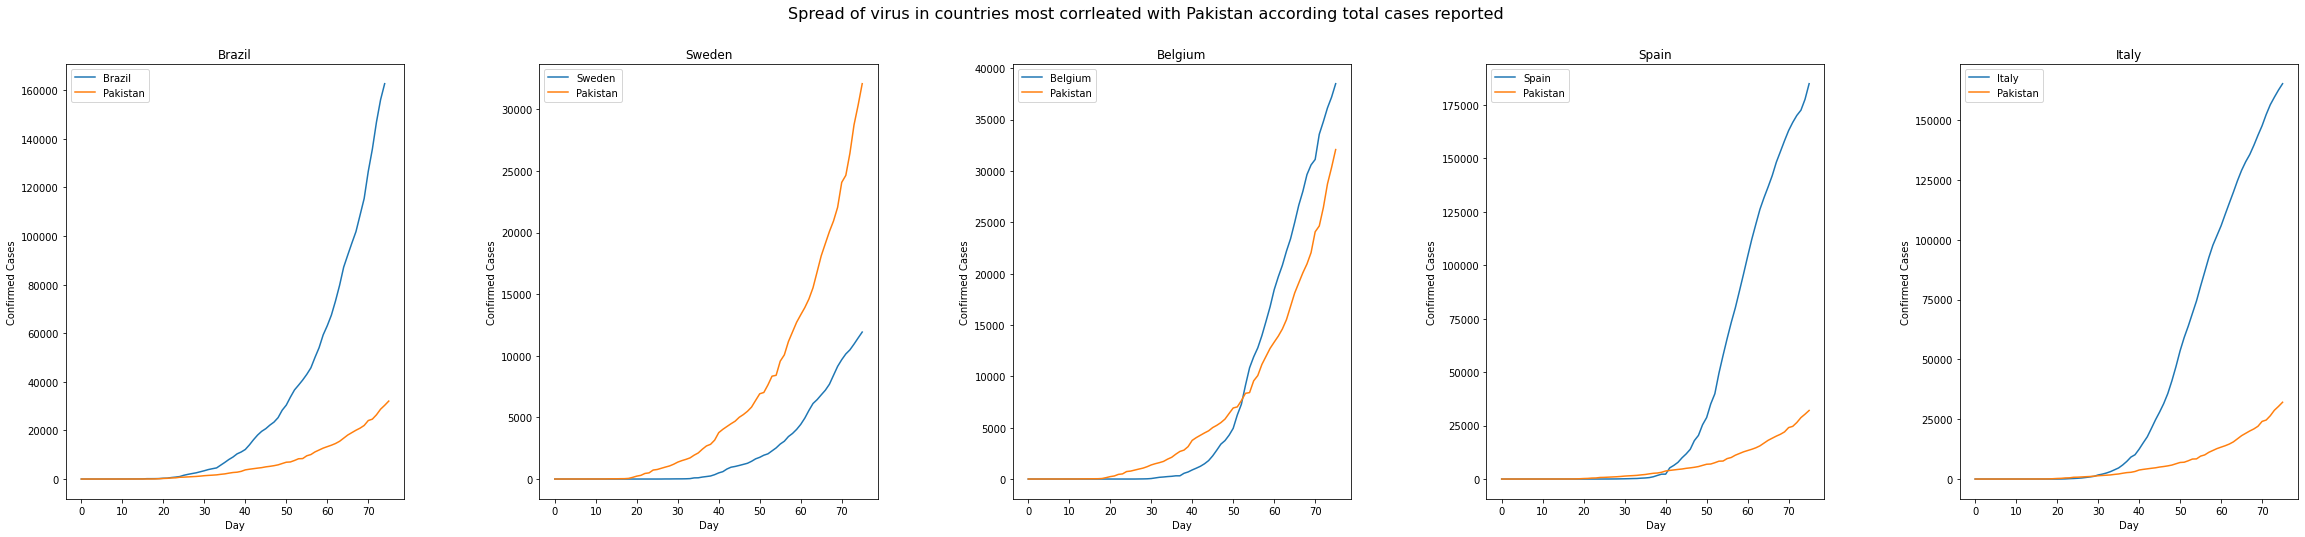

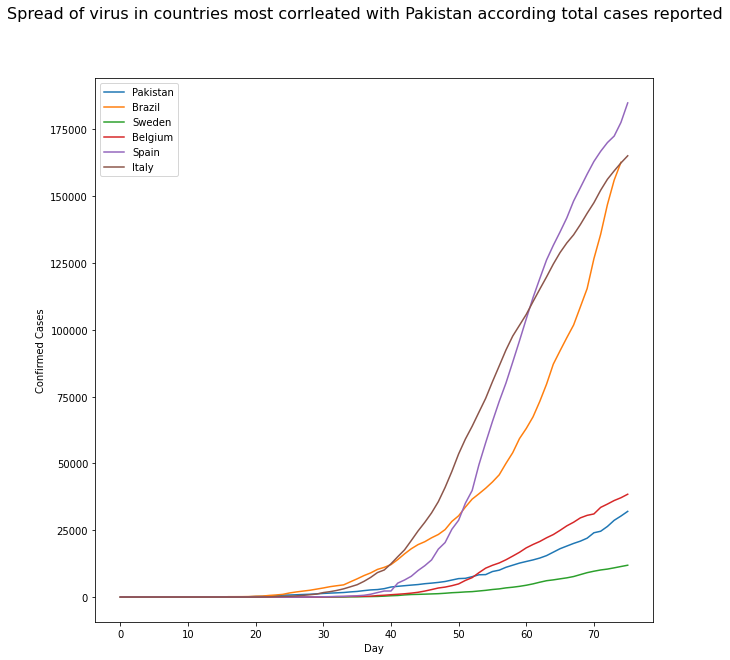

In [7]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE1,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE1,country,dataset)
printTrends(countryTrends,"Spread of virus in countries most corrleated with Pakistan according total cases reported")

## Comparing Countries w.r.t Difference between Cases per day

In [8]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE2,"Pakistan",dataset)
meanDiff = {}
for country in countries:
  countrySeries = getSeries(TYPE2,country,dataset)
  length = len(countrySeries)
  # if (TYPE2 != 2):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 1000 cases or with length less than pakistan
    continue
  dat1 = np.array([pakistanSeries[idx] for idx in range(rng)])
  dat2 = np.array([countrySeries[idx] for idx in range(rng)])
  meanDiff[country] = np.mean(np.abs(dat1 - dat2))
meanDiff = {k: v for k, v in sorted(meanDiff.items(),reverse = False, key=lambda item: item[1])}
print(meanDiff)

{'Pakistan': 0.0, 'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665, 'France': 7282.1466666666665, 'United Kingdom': 8871.573333333334, 'Switzerland': 9502.893333333333, 'Germany': 16217.573333333334, 'Brazil': 24645.306666666667, 'US': 29260.306666666667, 'Spain': 33188.96, 'Iran': 34565.46666666667, 'Italy': 35584.64, 'China': 54916.46666666667}


In [9]:
#getting only top 5 countires
relationValues = getTop5(meanDiff,False)
print(relationValues)

{'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665}


Pakistan 76
Belgium 97
Canada 106
Sweden 101
Russia 101
India 102


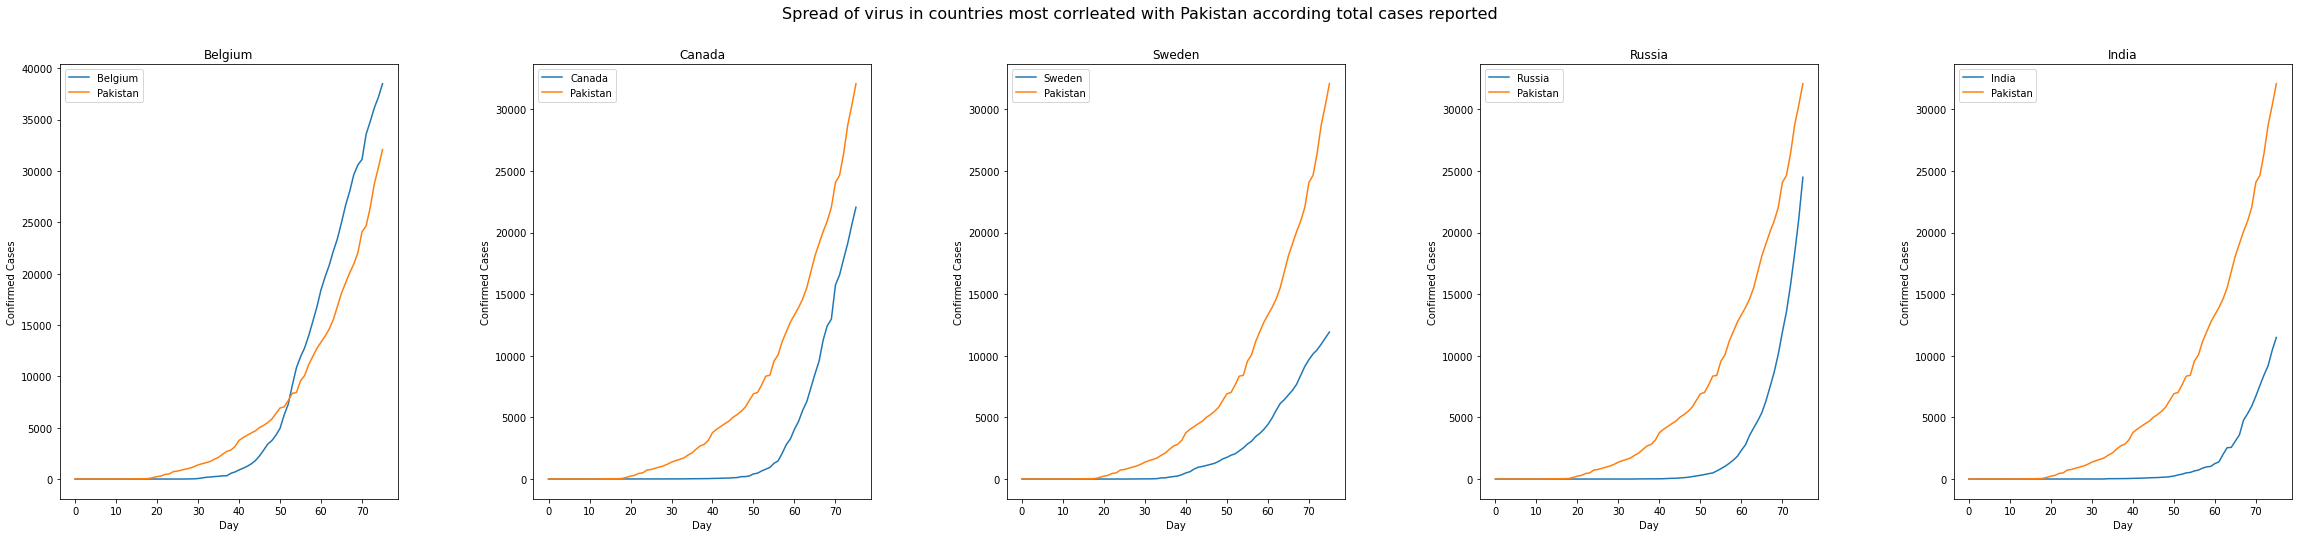

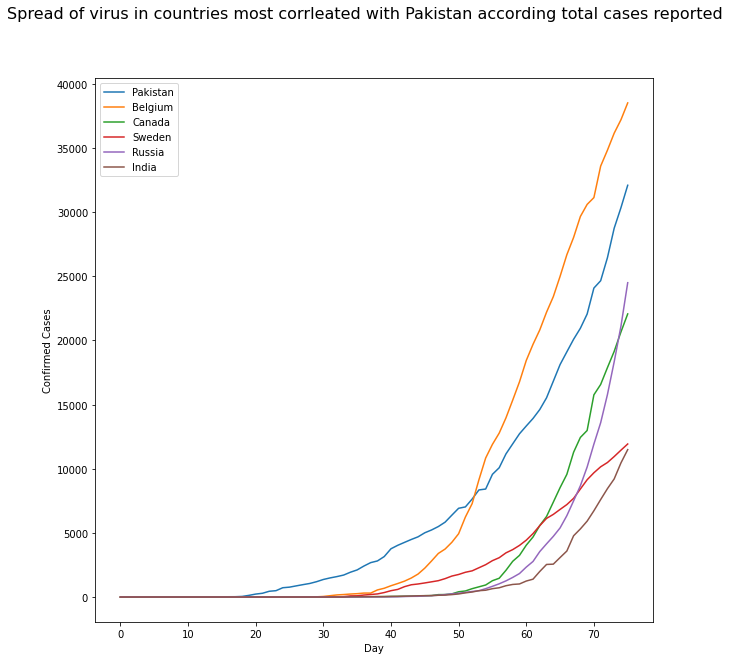

In [10]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Spread of virus in countries most corrleated with Pakistan according total cases reported')

## Final Selection based on both criteria

In [11]:
finalValues = {}
trend2 = {}
countries = list(meanDiff.keys())
for country in countries:
  trend2[country] = meanDiff[country]
maximumValue = (max(trend2.values()))
for country in countries:
  trend2[country] = abs(trend2[country] - maximumValue)
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
maximumValue2 = (max(trend2.values()))
for country in countries:
   trend2[country] = trend2[country]/maximumValue2
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
for country in countries:
  finalValues[country] = correlations[country] * 0.40 +  trend2[country] * 0.60
finalValues = {k: v for k, v in sorted(finalValues.items(),reverse = True, key=lambda item: item[1])}
print(finalValues)

{'Pakistan': 1.0, 'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913, 'France': 0.9069137328091728, 'United Kingdom': 0.8894111453020626, 'Germany': 0.8141526285976779, 'Switzerland': 0.8125089353416399, 'Brazil': 0.7296604733486634, 'US': 0.6403938616547713, 'Spain': 0.6298964800574685, 'Italy': 0.6031313247539418, 'Iran': 0.5821490020917308, 'China': 0.21908099116915758}


In [12]:
#getting only top 5 countires
relationValues = getTop5(finalValues,True)
print(relationValues)

{'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913}


Pakistan 76
Belgium 97
Sweden 101
Canada 106
Russia 101
India 102


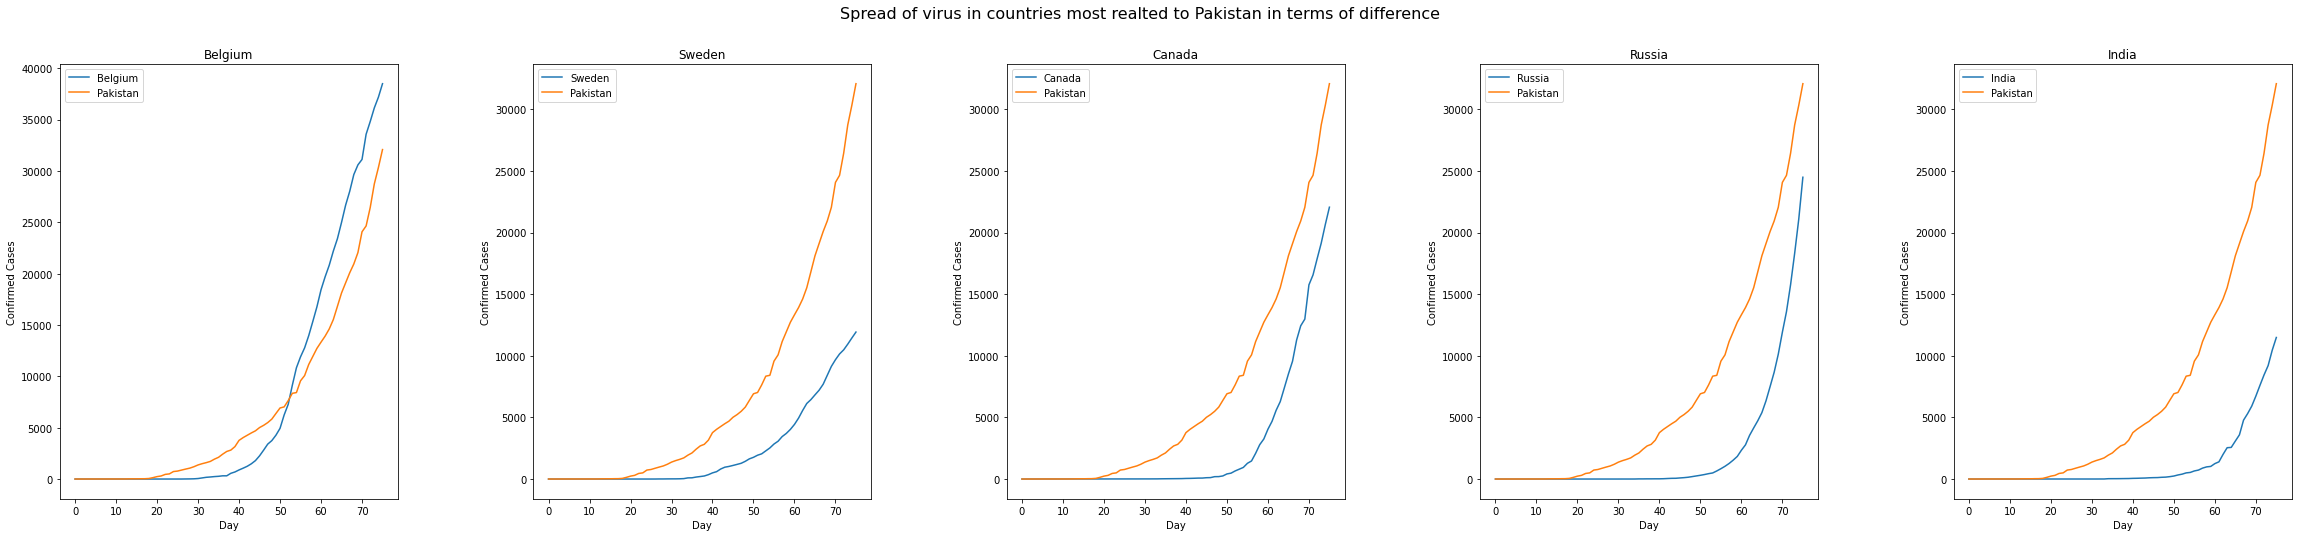

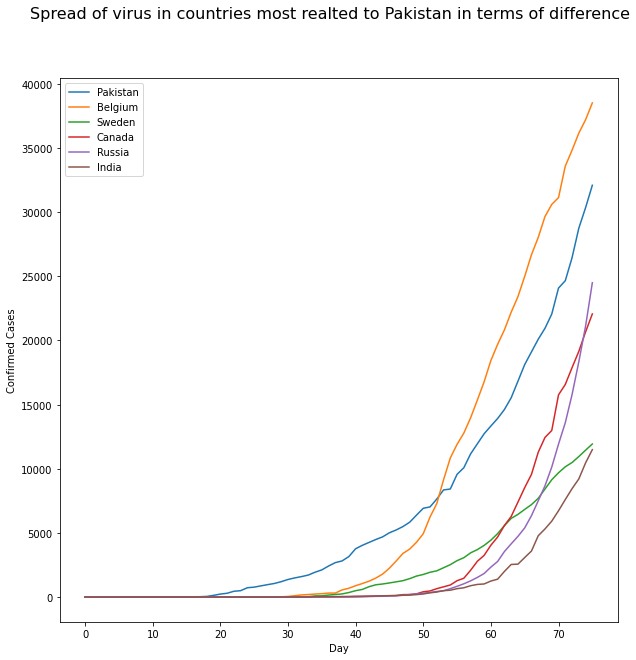

In [13]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Spread of virus in countries most realted to Pakistan in terms of difference')

Final selection is dependent upon combining learnings from both approaches, we gave 40% weightage to correlation and 60% to difference approach, based on final score, top 5 countries are.
1. Belgium
2. Sweden
3. Canada
4. Russia
5. India


Please note that the correlations and difference were compared for first 75 days of a country's exposure to the virus, since Pakistan has 75 days between first case until 10th May.  
Including any more days into our preliminary analysis would be actually cheating as then we would actually be peaking into the future and finiding correlated countries that are bound to give more acurate predictions, as we have already seen their trend beyond 10th May.


# Forecasting

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

In [16]:
# Utility functions
def getTimeSeriesTillDate(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = series.sum(axis = 0, skipna = True)
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def convertSeriesToActiveCases(series):
  newSeries = []
  newSeries.append(series[0])
  for i in range(len(series)-1):
    diff = series[i+1] - series[i] 
    newSeries.append(diff)
  return newSeries

def getDailyCaseSeries(country,dataset,date = '5/10/20',crop = True):
  series = getTimeSeriesTillDate(country,dataset,date,crop)
  return convertSeriesToActiveCases(series)


## Approach 1 (LSTM trained on non-stationary series)

The analysis below is based on top 5 countires picked via the observations above.  
- Each country is used to predict cases from 10th May to 27th May period of pakistan(training is done for first 74 days). Test RMSE are computed in this case for cases between 10th and 27th may, and predicted cases
-  Each country is also used to predict cases from 27th May to 27th June period of pakistan(training is done for first 92 days).  
- Each country data is trained on the same model, with same configurations
- The  daily cases series is kept non-stationary in this case, as LSTM have no pre-condition of stationary series

In [17]:
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
register_matplotlib_converters()
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [18]:
pred_trend = {}
test_rmse = {}
train_rmse = {}
pak_rmse = {}
pred_trend_fut = {}

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def train_LSTM_model(model,epochs,train_data,test_data = None):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_hist = []
  test_hist = []
  for i in range(epochs):
    train_loss = 0
    test_loss = 0
    for seq, labels in train_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        train_loss += single_loss.item()
        single_loss.backward()
        optimizer.step()

    train_loss = train_loss/len(train_data) 
    train_hist.append(train_loss)
    if test_data is not None:
      with torch.no_grad():
        for seq, labels in test_data:
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
          y_pred = model(seq)
          single_loss = loss_function(y_pred, labels)
          test_loss += single_loss.item()
        test_loss = test_loss/len(test_data) 
        test_hist.append(test_loss)
      if i % 5 == 0:
        print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
    elif i % 5 == 0:
      print(f'Epoch {i} train loss: {train_loss}')
  if test_data is not None:
    print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
  else:
    print(f'Epoch {i} train loss: {train_loss}')
  return model.eval(),train_hist,test_hist

In [20]:
def create_sequences(series, window):
    sequences = []
    for i in range(len(series)-window):
        sample_seq = series[i:i+window]
        label = series[i+window:i+window+1]
        sequences.append((sample_seq ,label))
    return sequences

### Belgium


#### Prediction from 10th May to 27th May

In [21]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

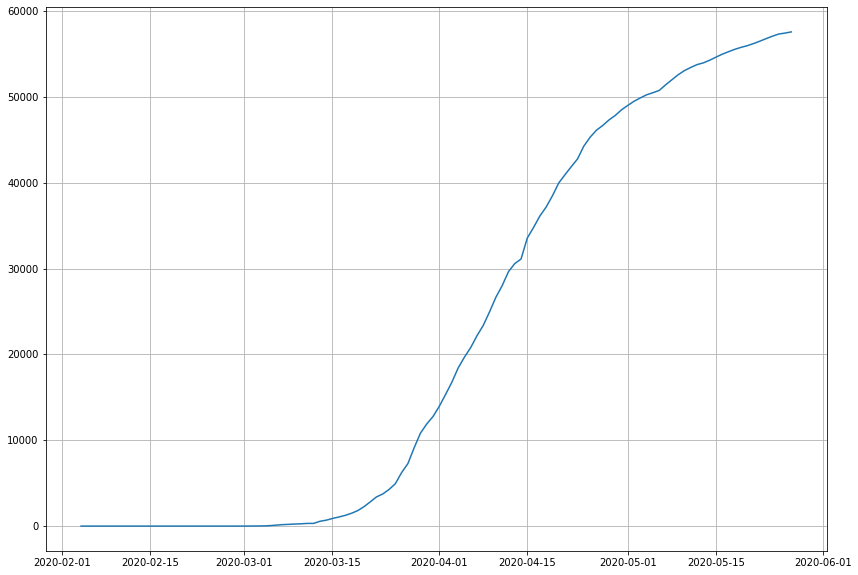

In [22]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

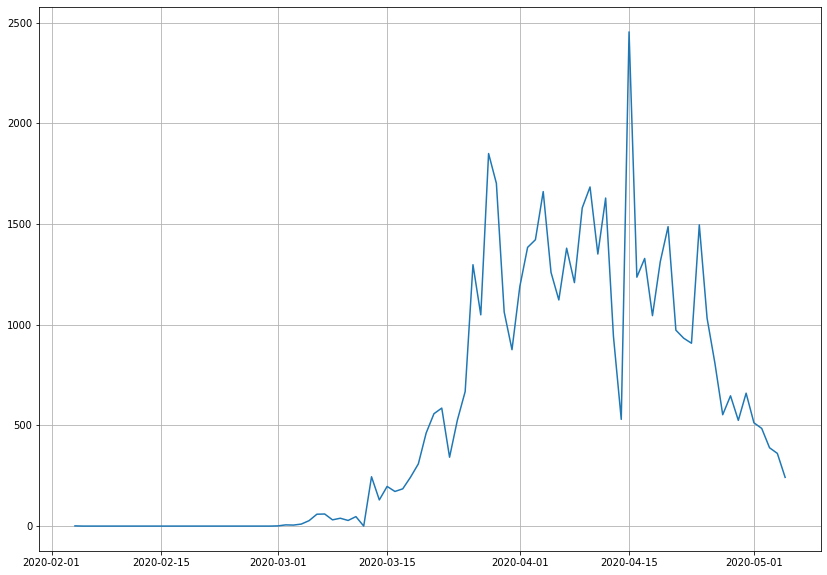

In [23]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

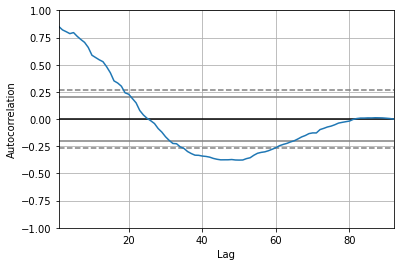

In [24]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 5, as the values are most correalted for that range

In [25]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [26]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [27]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [28]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.014227247728979365 test loss: 0.06744432825750361
Epoch 5 train loss: 0.02433168774535131 test loss: 0.02525031011706839
Epoch 10 train loss: 0.01807104257313245 test loss: 0.02620479363637666
Epoch 15 train loss: 0.015619001808412795 test loss: 0.031211020657792687
Epoch 20 train loss: 0.013767212911008844 test loss: 0.03612233426732322
Epoch 25 train loss: 0.01155106421958619 test loss: 0.044961756793782115
Epoch 30 train loss: 0.011962806755546668 test loss: 0.055939555750228465
Epoch 35 train loss: 0.011639760460106377 test loss: 0.05940525763435289
Epoch 40 train loss: 0.01137278097893386 test loss: 0.06359506437244515
Epoch 45 train loss: 0.011124435912570618 test loss: 0.06819085468305275
Epoch 50 train loss: 0.010876079380078757 test loss: 0.0732624309748644
Epoch 55 train loss: 0.010623852393415843 test loss: 0.0788205874923733
Epoch 60 train loss: 0.010366462775333015 test loss: 0.08394608404595753
Epoch 65 train loss: 0.010058402341705427 test loss: 0.0

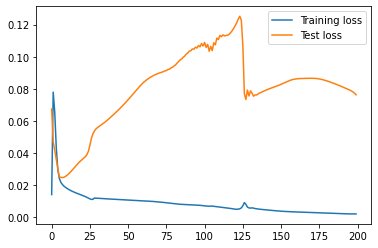

In [30]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [31]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.052813127636909485, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05273692309856415, 0.05294804275035858, 0.05410149693489075, 0.05423417687416077, 0.054570674896240234, 0.059467095881700516, 0.06747673451900482, 0.06891371309757233, 0.05997980386018753, 0.06431692838668823, 0.07097270339727402, 0.06782124936580658, 0.060572460293769836, 0.10437341034412384, 0.11778581142425537, 0.06164577603340149, 0.13886435329914093, 0.10579804331064224, 0.14463216066360474, 0.1610109955072403, 0.1913316547870636, 0.24404382705688477, 0.24124638736248016, 0.23474156856536865, 0.27796655893325806, 0.53338509798

In [32]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1183 Actual 1313
Predicted 2521 Actual 1487
Predicted 1497 Actual 973
Predicted 1133 Actual 933
Predicted 1246 Actual 908
Predicted 1268 Actual 1496
Predicted 1940 Actual 1032
Predicted 1628 Actual 809
Predicted 1228 Actual 553
Predicted 1330 Actual 647
Predicted 1375 Actual 525
Predicted 1648 Actual 660
Predicted 1597 Actual 513
Predicted 1277 Actual 485
Predicted 1410 Actual 389
Predicted 1492 Actual 361
Predicted 1441 Actual 242
Train RMSE =  125.43027451914617
Test RMSE =  813.6752076460521
RMSE Against Pakistan =  888.8772820381846


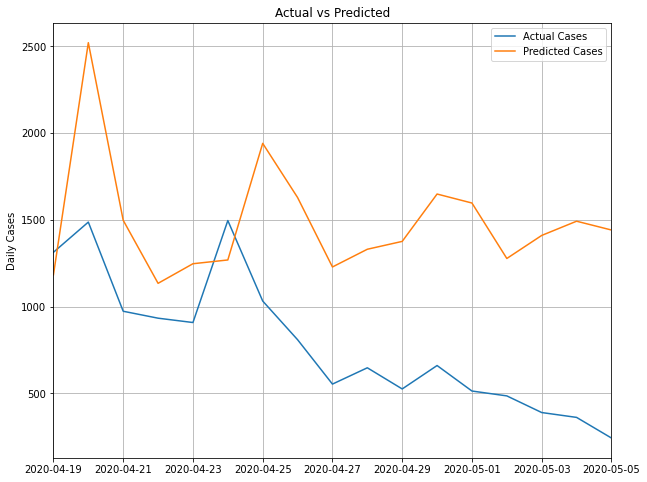

In [33]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

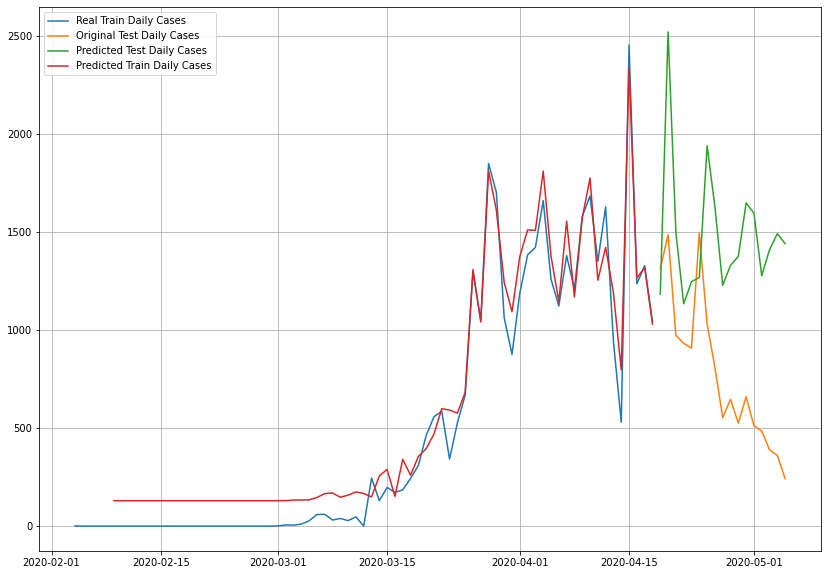

In [34]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

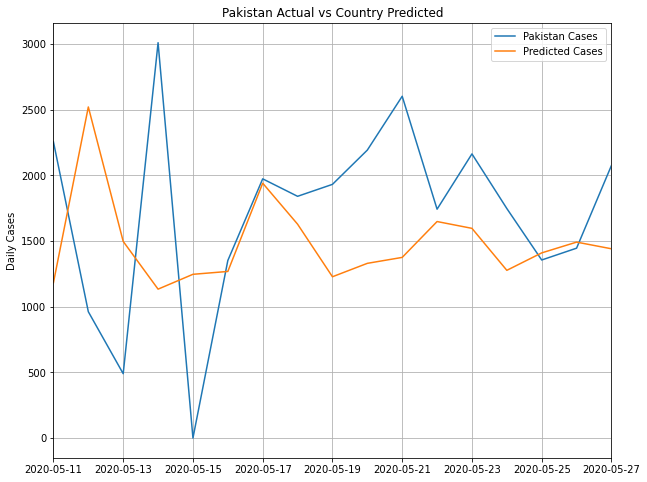

In [35]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [36]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

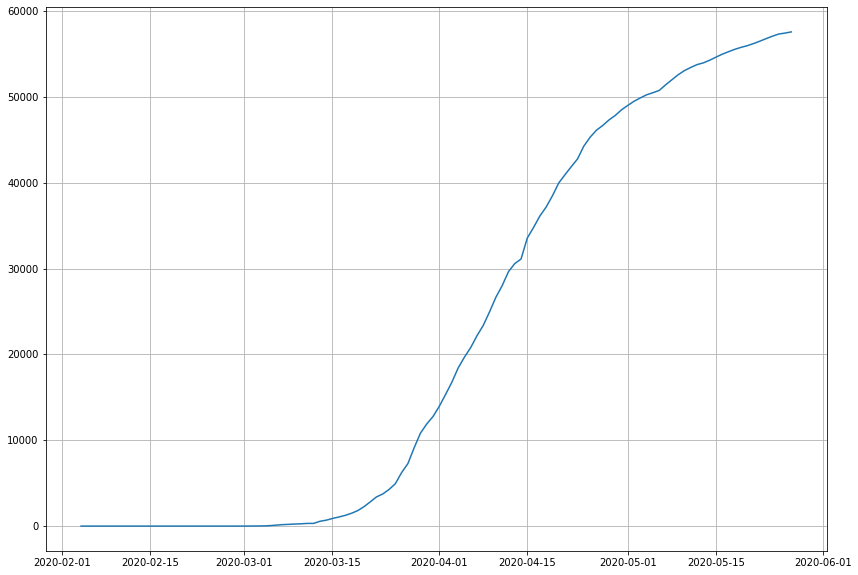

In [37]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

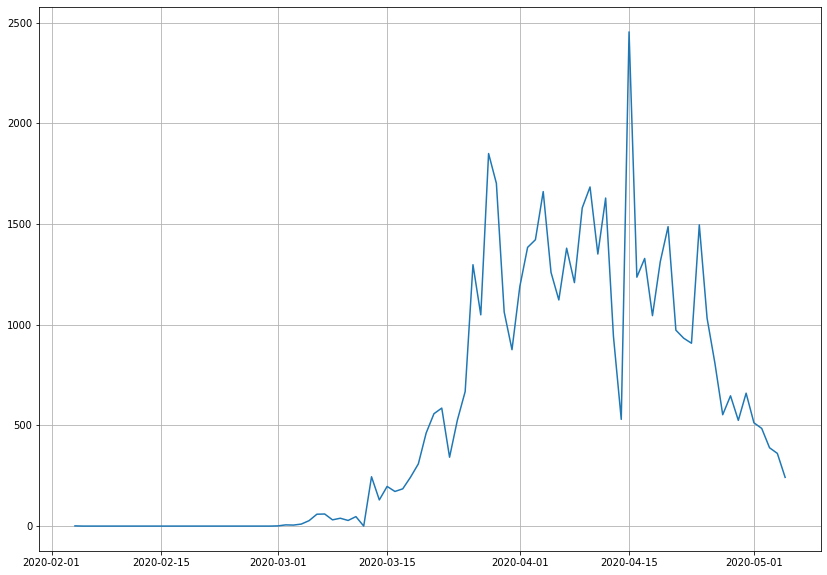

In [38]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

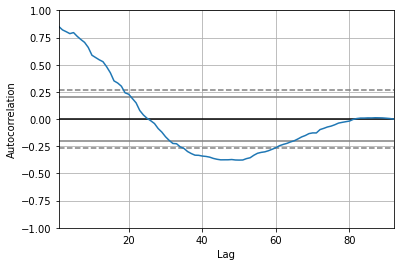

In [39]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 10, as the values are most correalted for that range

In [40]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [41]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [42]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.

In [43]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.021198159175358038
Epoch 5 train loss: 0.03974398297261481
Epoch 10 train loss: 0.02103184046623267
Epoch 15 train loss: 0.018087679243488464
Epoch 20 train loss: 0.017111552459668264
Epoch 25 train loss: 0.016781244581036248
Epoch 30 train loss: 0.01617208195205881
Epoch 35 train loss: 0.015356415853371379
Epoch 40 train loss: 0.01494316708308021
Epoch 45 train loss: 0.013516278329183633
Epoch 50 train loss: 0.012520736748212231
Epoch 55 train loss: 0.012797093796435996
Epoch 60 train loss: 0.011042028320138767
Epoch 65 train loss: 0.010798803489151531
Epoch 70 train loss: 0.009583492468028861
Epoch 75 train loss: 0.008922207268441076
Epoch 80 train loss: 0.007906354219165322
Epoch 85 train loss: 0.007352431226536282
Epoch 90 train loss: 0.006741697832007696
Epoch 95 train loss: 0.004985084411107617
Epoch 100 train loss: 0.008234346093473038
Epoch 105 train loss: 0.0045150997353597165
Epoch 110 train loss: 0.003966853783020744
Epoch 115 train loss: 0.002454567071

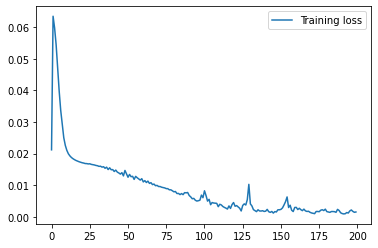

In [44]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [45]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.04531046748161316, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04532131552696228, 0.04556289315223694, 0.046825096011161804, 0.04676155745983124, 0.047453030943870544, 0.05198653042316437, 0.06042809784412384, 0.061156660318374634, 0.0506783127784729, 0.05075138807296753, 0.052338823676109314, 0.05475252866744995, 0.0449795126914978, 0.10235507041215897, 0.09562630206346512, 0.08104559779167175, 0.08946845680475235, 0.08552709966897964, 0.10465769469738007, 0.1305759996175766, 0.17961344122886658, 0.2291991412639618, 0.23454073071479797, 0.13531272113323212, 0.14296114444732666, 0.3973269462585449, 0.45240598917007446, 0.7207592725753784, 0.7351441383361816, 0.4376366436481476, 0.3748546242713928,

In [46]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
actual_predictions[actual_predictions < 0] = 0
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  130.25406408201107


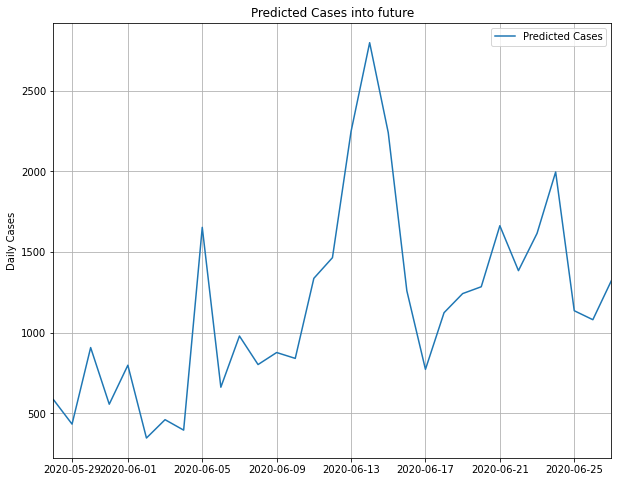

In [47]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

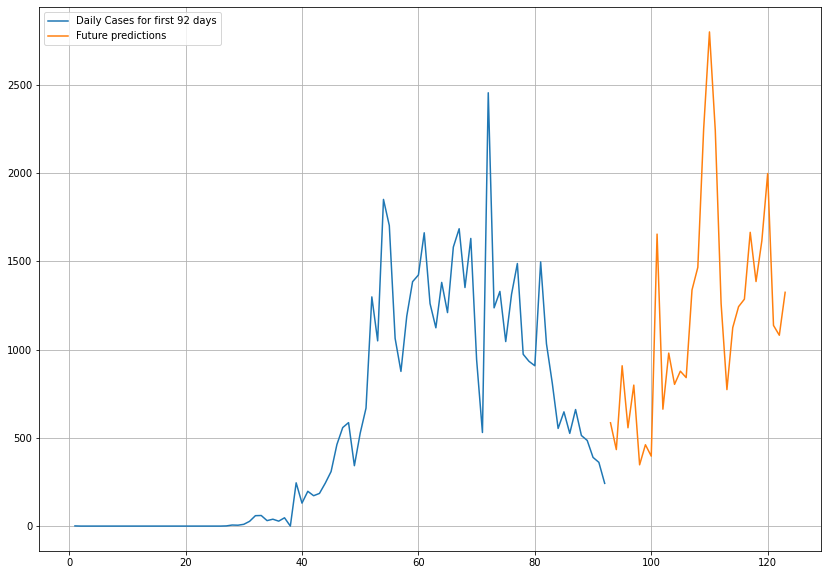

In [48]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Sweden


#### Predictions from 10th May to 27th May

In [49]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

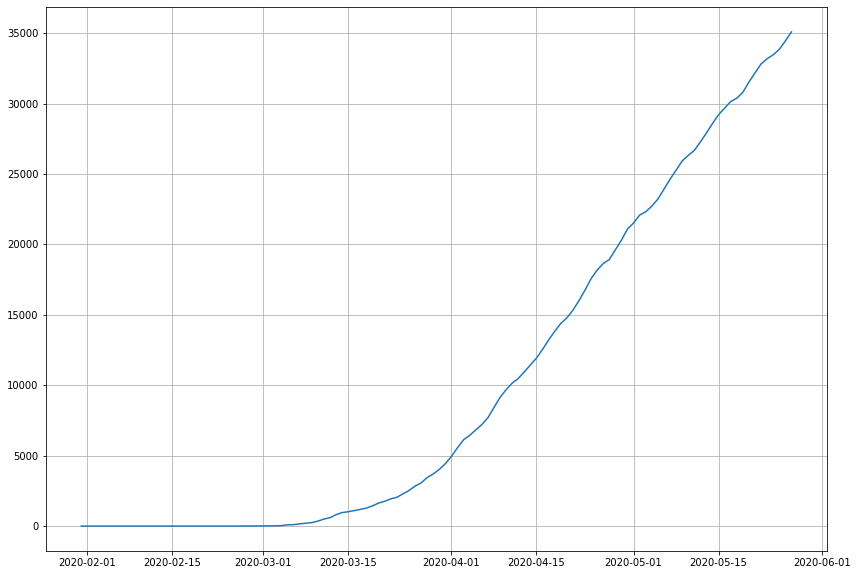

In [50]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

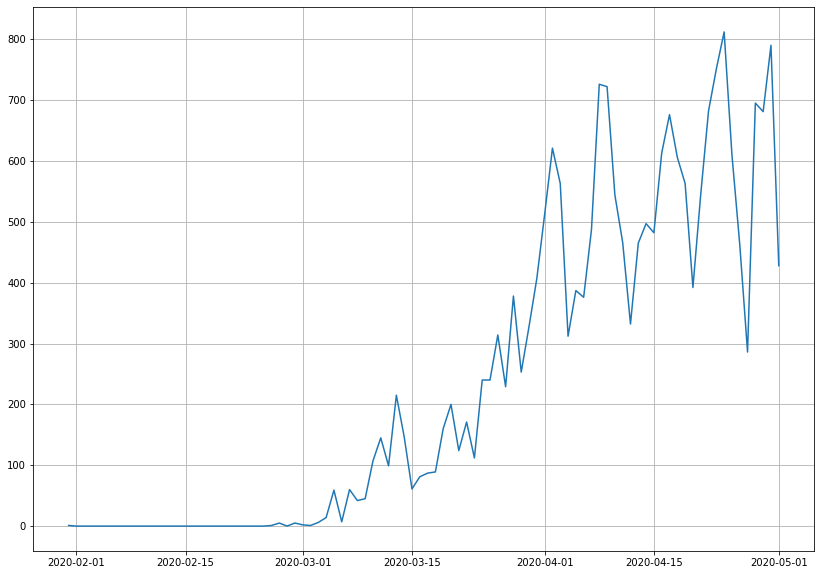

In [51]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

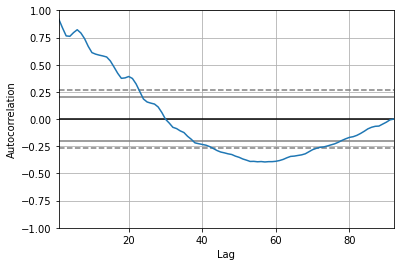

In [52]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 5, as the values are most correalted for that range

In [53]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [54]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [55]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [56]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.011860044799941015 test loss: 0.04690098671320205
Epoch 5 train loss: 0.023594443693853266 test loss: 0.052572550426702946
Epoch 10 train loss: 0.012143684991643307 test loss: 0.04660296187891314
Epoch 15 train loss: 0.00914253397058157 test loss: 0.044256473610100024
Epoch 20 train loss: 0.008286020962094045 test loss: 0.041413931214871504
Epoch 25 train loss: 0.007738382512911812 test loss: 0.03494239350159963
Epoch 30 train loss: 0.00669902599832629 test loss: 0.025706527480906516
Epoch 35 train loss: 0.005970223565509818 test loss: 0.025801001304292488
Epoch 40 train loss: 0.005606104031715274 test loss: 0.02655797990883002
Epoch 45 train loss: 0.005287470787154039 test loss: 0.02681245721517674
Epoch 50 train loss: 0.004920476465642411 test loss: 0.026462425565114245
Epoch 55 train loss: 0.004756746168181637 test loss: 0.026700698112108512
Epoch 60 train loss: 0.005247087027068277 test loss: 0.0246933779817482
Epoch 65 train loss: 0.0052559959267252255 test l

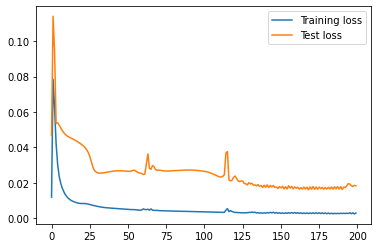

In [57]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [58]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.019521653652191162, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.019557848572731018, 0.020082898437976837, 0.022644706070423126, 0.021825343370437622, 0.022327817976474762, 0.02322573959827423, 0.020892783999443054, 0.02360919862985611, 0.029720410704612732, 0.05841430649161339, 0.04946253448724747, 0.053570982068777084, 0.07530613243579865, 0.06241733208298683, 0.10860541462898254, 0.16112130880355835, 0.1474437266588211, 0.19907812774181366, 0.22677266597747803, 0.11783395707607269, 0.11857617646455765, 0.12483635544776917, 0.11478999257087708, 0.1630740761756897, 0.2332049

In [59]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 625 Actual 482
Predicted 829 Actual 613
Predicted 792 Actual 676
Predicted 306 Actual 606
Predicted 336 Actual 563
Predicted 447 Actual 392
Predicted 565 Actual 545
Predicted 633 Actual 682
Predicted 636 Actual 751
Predicted 441 Actual 812
Predicted 290 Actual 610
Predicted 432 Actual 463
Predicted 501 Actual 286
Predicted 659 Actual 695
Predicted 881 Actual 681
Predicted 750 Actual 790
Predicted 194 Actual 428
Train RMSE =  37.37785827729104
Test RMSE =  191.8205366441506
RMSE Against Pakistan =  1423.7789129209366


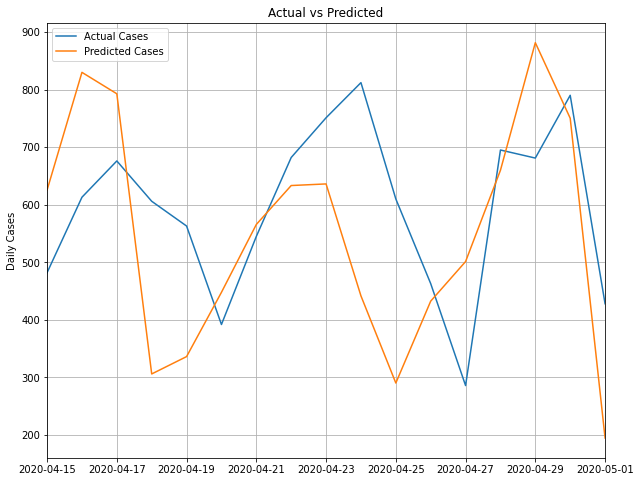

In [60]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

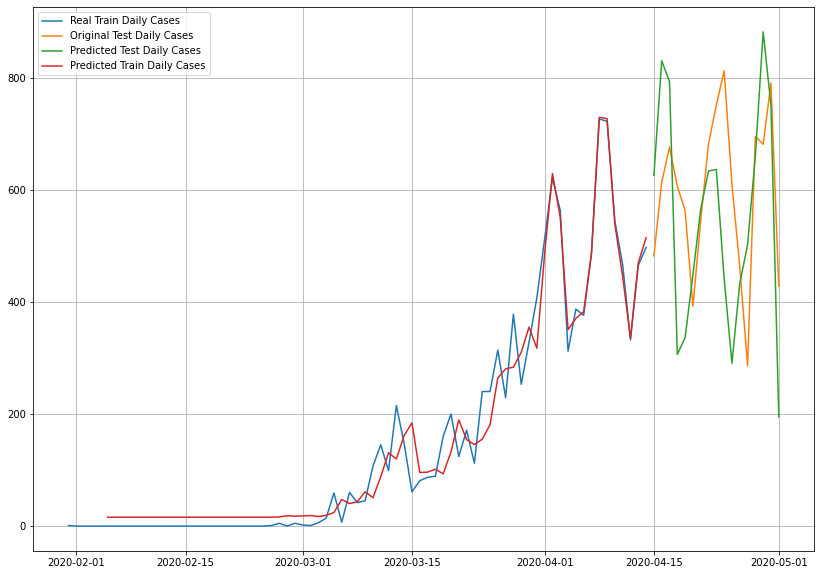

In [61]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

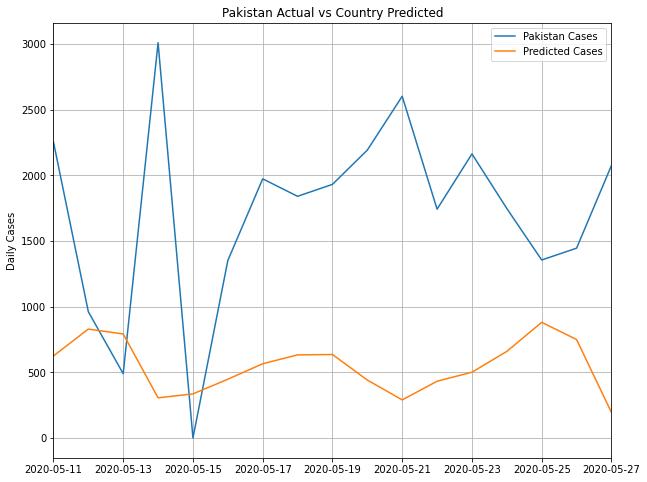

In [62]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [63]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

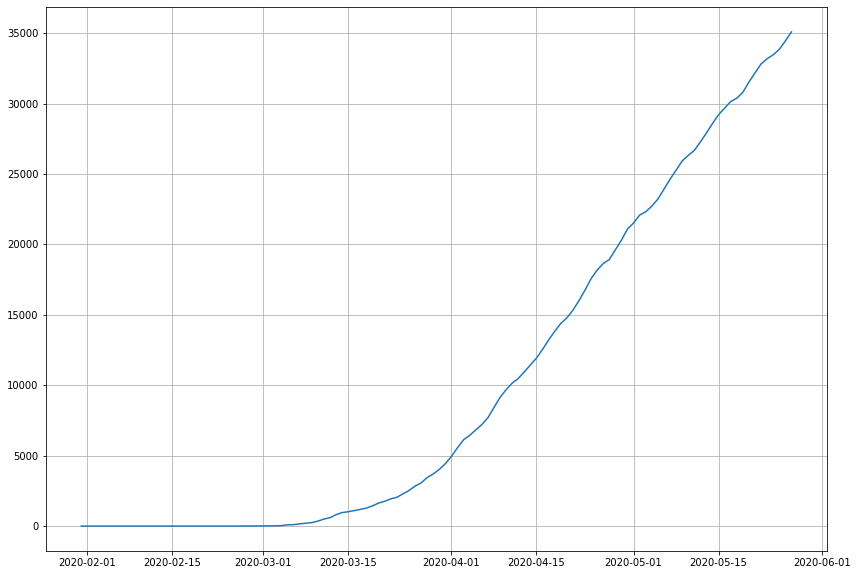

In [64]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

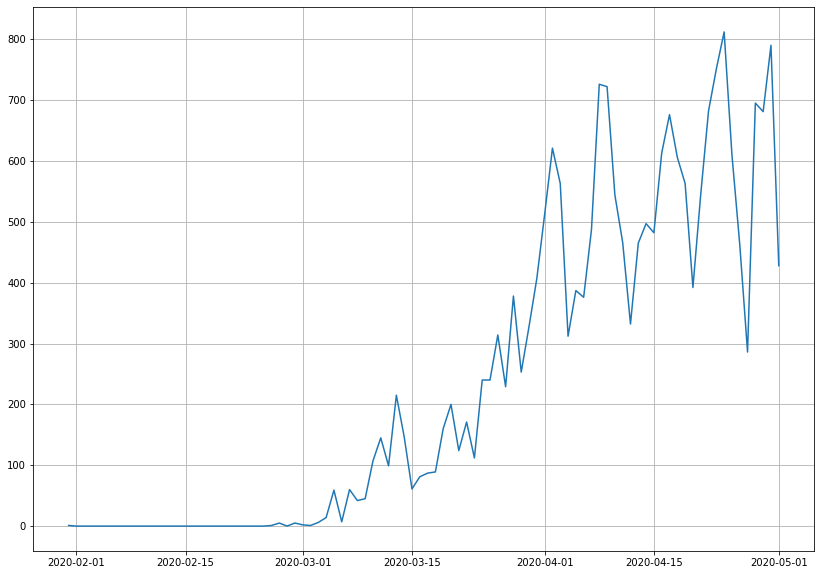

In [65]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

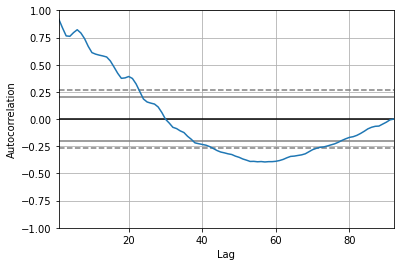

In [66]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 7, as the values are most correalted for that range

In [67]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [68]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [69]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [70]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.018474269619679597
Epoch 5 train loss: 0.03125435677434325
Epoch 10 train loss: 0.01569486859583348
Epoch 15 train loss: 0.01314200410342691
Epoch 20 train loss: 0.010744753506754403
Epoch 25 train loss: 0.010359393756243663
Epoch 30 train loss: 0.00960331874005659
Epoch 35 train loss: 0.009105097760487645
Epoch 40 train loss: 0.008827612664121302
Epoch 45 train loss: 0.008668522526361144
Epoch 50 train loss: 0.008562589795613739
Epoch 55 train loss: 0.00847954529550074
Epoch 60 train loss: 0.008399501842422176
Epoch 65 train loss: 0.00832381333181816
Epoch 70 train loss: 0.008251119739559406
Epoch 75 train loss: 0.008133290305533378
Epoch 80 train loss: 0.007909211361918005
Epoch 85 train loss: 0.007592310824889423
Epoch 90 train loss: 0.007243689662006064
Epoch 95 train loss: 0.00690023653238223
Epoch 100 train loss: 0.006605451269771703
Epoch 105 train loss: 0.006401353596420733
Epoch 110 train loss: 0.006246407055575071
Epoch 115 train loss: 0.0060999244453067

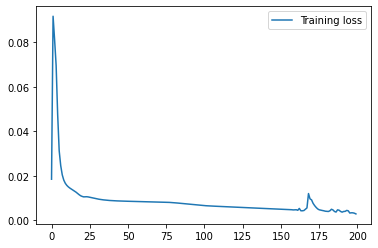

In [71]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [72]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.02205778658390045, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.021945402026176453, 0.02243770658969879, 0.02500225603580475, 0.02495458722114563, 0.02435384690761566, 0.024435117840766907, 0.023795336484909058, 0.025127694010734558, 0.03225432336330414, 0.06053607165813446, 0.06020156294107437, 0.05366987735033035, 0.0622517466545105, 0.07088737189769745, 0.09938814491033554, 0.15742020308971405, 0.15801778435707092, 0.168114572763443, 0.20316322147846222, 0.14693516492843628, 0.09320226311683655, 0.13278548419475555, 0.1864480972290039, 0.21437221765518188, 0.23310494422912598, 0.2022903561592102, 0.1568256914615631,

In [73]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  38.911369497542914


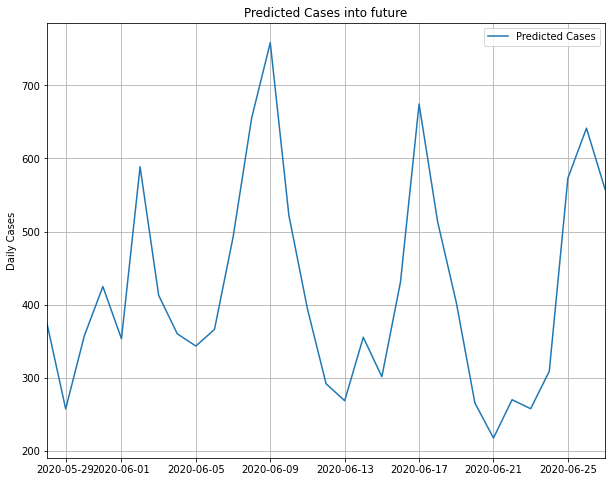

In [74]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

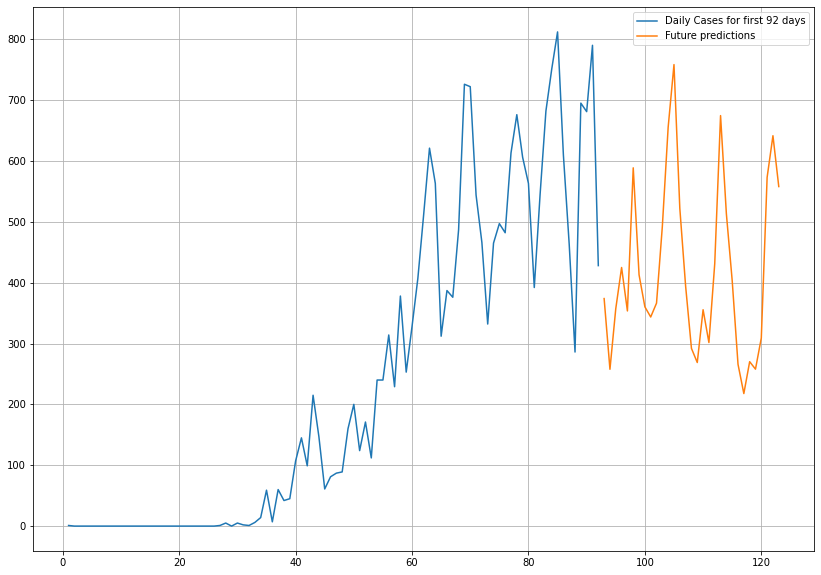

In [75]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### India


#### Predictions from 10th May to 27th May

In [76]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

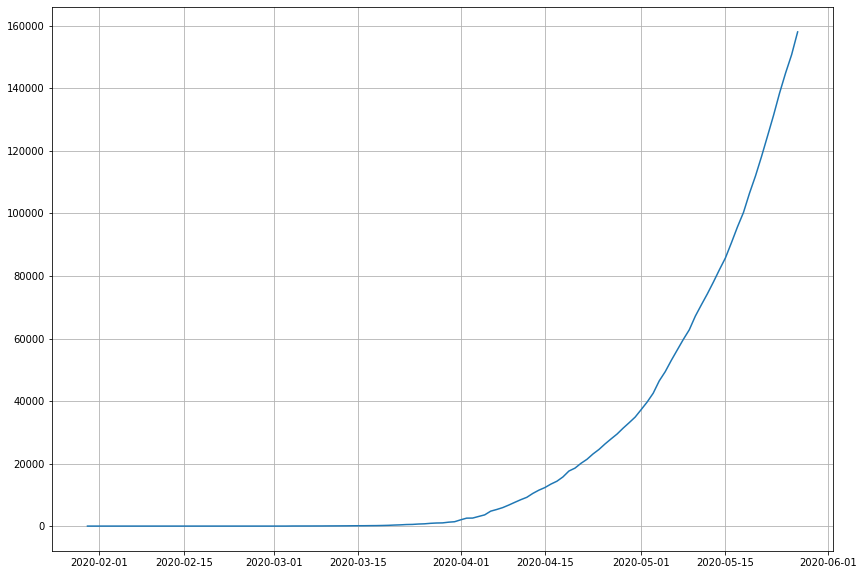

In [77]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

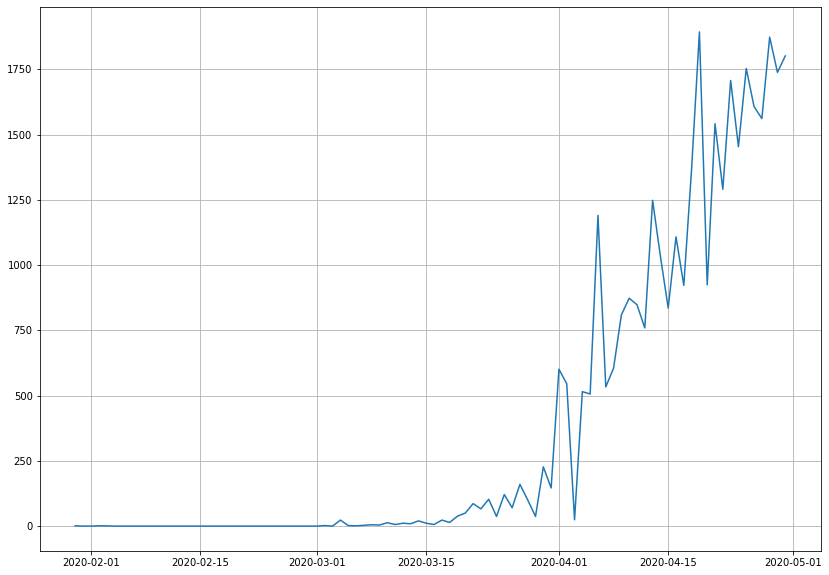

In [78]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

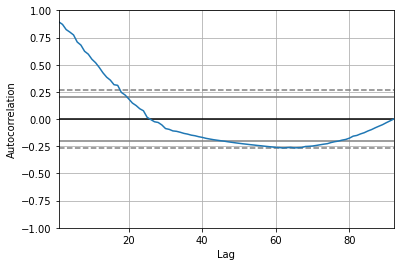

In [79]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [80]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [81]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [82]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0008, 0.0000, 0.0000, 0.0008, 0.0008]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0008, 0.0008, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0008, 0.0008, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0008, 0.0008, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0008, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 

In [83]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.02702224518135587 test loss: 0.5673052088047067
Epoch 5 train loss: 0.018586305209000134 test loss: 0.06363548082784594
Epoch 10 train loss: 0.02156797610669433 test loss: 0.1842017074037964
Epoch 15 train loss: 0.012239241085109955 test loss: 0.04721739741944475
Epoch 20 train loss: 0.010331296341330898 test loss: 0.10928078119953473
Epoch 25 train loss: 0.009981053336904569 test loss: 0.10034546664004058
Epoch 30 train loss: 0.008399492559378099 test loss: 0.17880265321582556
Epoch 35 train loss: 0.009071630197914666 test loss: 0.1718618997062246
Epoch 40 train loss: 0.008372385399280802 test loss: 0.23581171103675538
Epoch 45 train loss: 0.008893275477156034 test loss: 0.1955842898848156
Epoch 50 train loss: 0.007934826898938268 test loss: 0.2590943914838135
Epoch 55 train loss: 0.008855227629309022 test loss: 0.21807690143274763
Epoch 60 train loss: 0.0077427089857539004 test loss: 0.28006109813486546
Epoch 65 train loss: 0.00863910986760337 test loss: 0.23842

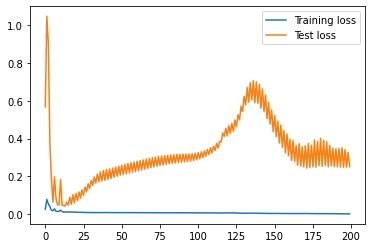

In [84]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [85]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.06663009524345398, -0.06804901361465454, -0.06945481896400452, -0.06860709190368652, -0.06763997673988342, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.0684870183467865, -0.06733256578445435, -0.06762373447418213, -0.055148541927337646, -0.059135645627975464, -0.06392121315002441, -0.08654060959815979, -0.04610984027385712, -0.06328293681144714, -0.061289966106414795, -0.06150561571121216, -0.05898001790046692, -0.06690579652786255, -0.0476553738117218, -0.05828455090522766, -0.05920472741127014, -0.0629633367061615, -0.04179450869560242, -0.0365225225

In [86]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 690 Actual 1034
Predicted 1154 Actual 835
Predicted 701 Actual 1108
Predicted 1094 Actual 922
Predicted 782 Actual 1370
Predicted 1016 Actual 1892
Predicted 830 Actual 924
Predicted 957 Actual 1541
Predicted 880 Actual 1290
Predicted 924 Actual 1707
Predicted 903 Actual 1453
Predicted 905 Actual 1753
Predicted 915 Actual 1607
Predicted 900 Actual 1561
Predicted 918 Actual 1873
Predicted 899 Actual 1738
Predicted 917 Actual 1800
Train RMSE =  82.3843801282539
Test RMSE =  641.0777425493661
RMSE Against Pakistan =  1068.9983757005311


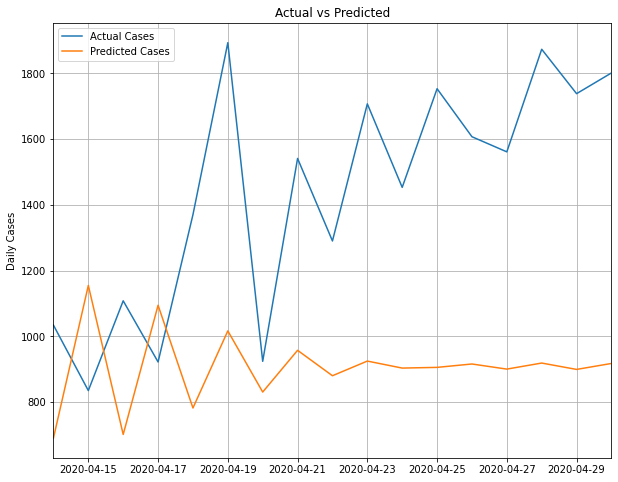

In [87]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

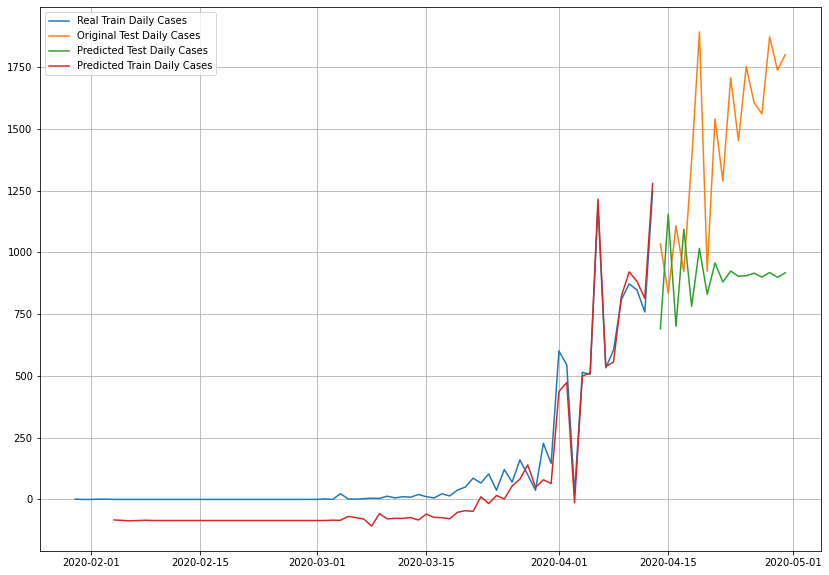

In [88]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

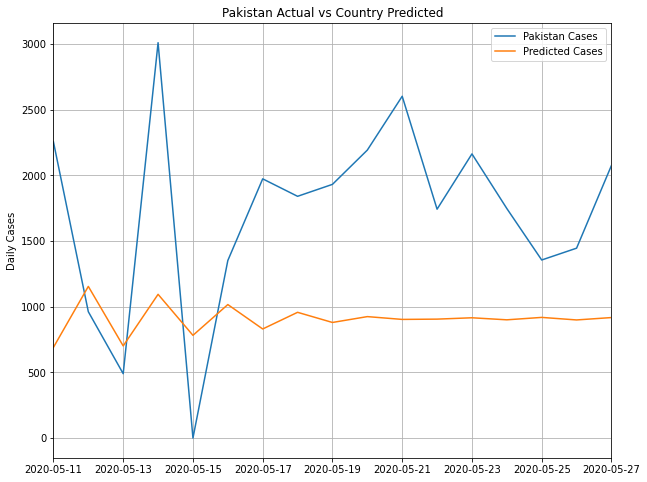

In [89]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [90]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

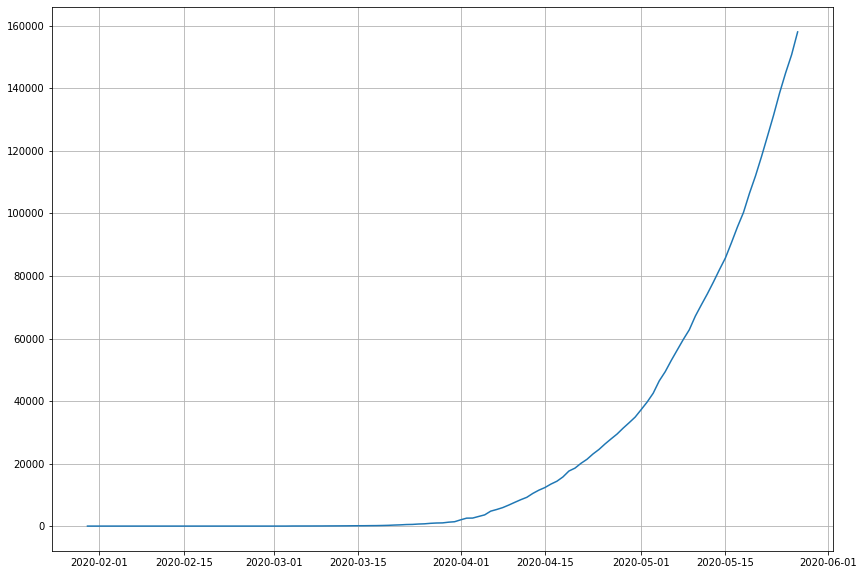

In [91]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

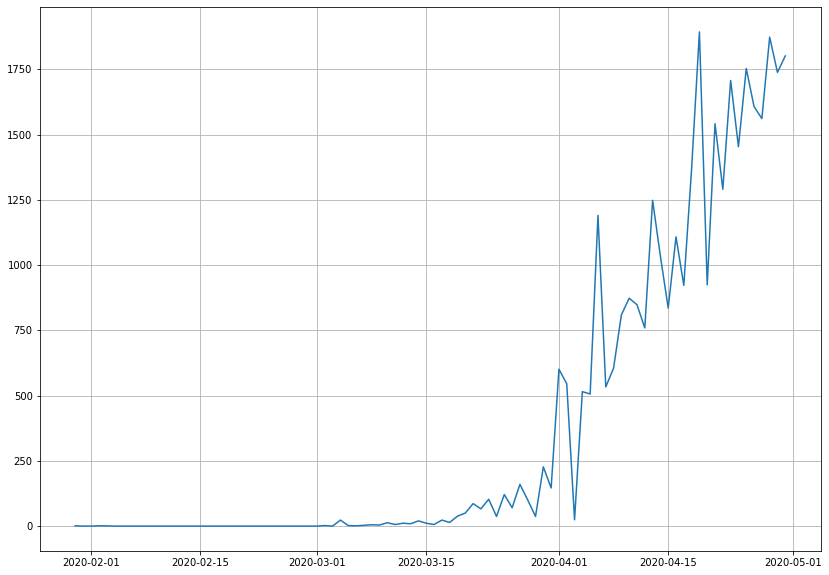

In [92]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

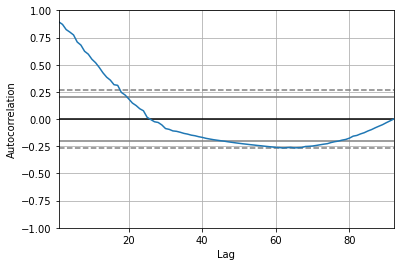

In [93]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [94]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [95]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [96]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0005, 0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 

In [97]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.012208632570706214
Epoch 5 train loss: 0.020686806473549507
Epoch 10 train loss: 0.009324222408134497
Epoch 15 train loss: 0.008419493277999561
Epoch 20 train loss: 0.008532813880952833
Epoch 25 train loss: 0.008502428618722139
Epoch 30 train loss: 0.008186441954568713
Epoch 35 train loss: 0.0077749631817069466
Epoch 40 train loss: 0.00924341864909299
Epoch 45 train loss: 0.007812800648543308
Epoch 50 train loss: 0.007629315865356163
Epoch 55 train loss: 0.007236475502650321
Epoch 60 train loss: 0.006766879005505327
Epoch 65 train loss: 0.00627269584939508
Epoch 70 train loss: 0.005834946132295402
Epoch 75 train loss: 0.005921106633732343
Epoch 80 train loss: 0.0063270485999230765
Epoch 85 train loss: 0.005962761649086852
Epoch 90 train loss: 0.0050646201179059686
Epoch 95 train loss: 0.005760265802998688
Epoch 100 train loss: 0.008757074071349657
Epoch 105 train loss: 0.00551320686702905
Epoch 110 train loss: 0.004825194493362378
Epoch 115 train loss: 0.004902749

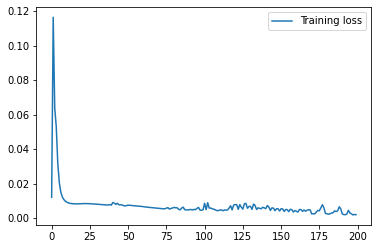

In [98]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [99]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.030299678444862366, 0.03023320436477661, 0.030294090509414673, 0.030313774943351746, 0.030328795313835144, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.03035879135131836, 0.031122416257858276, 0.030338406562805176, 0.03897269070148468, 0.031164661049842834, 0.029546812176704407, 0.035912737250328064, 0.03849758207798004, 0.03324982523918152, 0.03405150771141052, 0.032607659697532654, 0.035142362117767334, 0.03598509728908539, 0.041124291718006134, 0.03724890947341919, 0.03455512225627899, 0.04368194192647934, 0.04118328541517258, 0.045987047255039215, 0.05158071219921112, 0.06488151103258133, 0.059940069913864136, 0.07989784330129623, 0.06778022646903992, 0

In [100]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  104.91279184717799


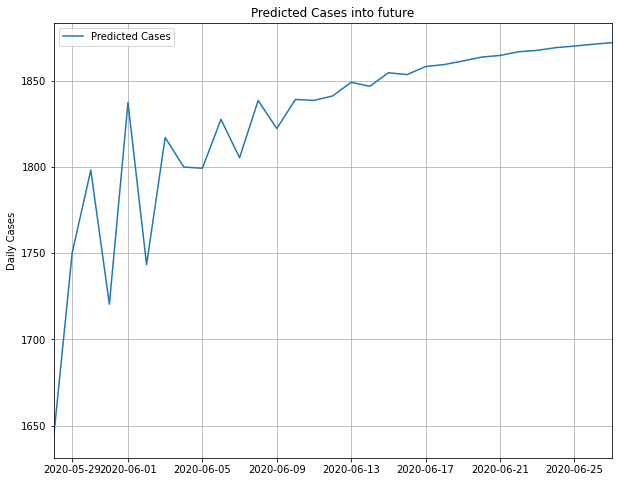

In [101]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

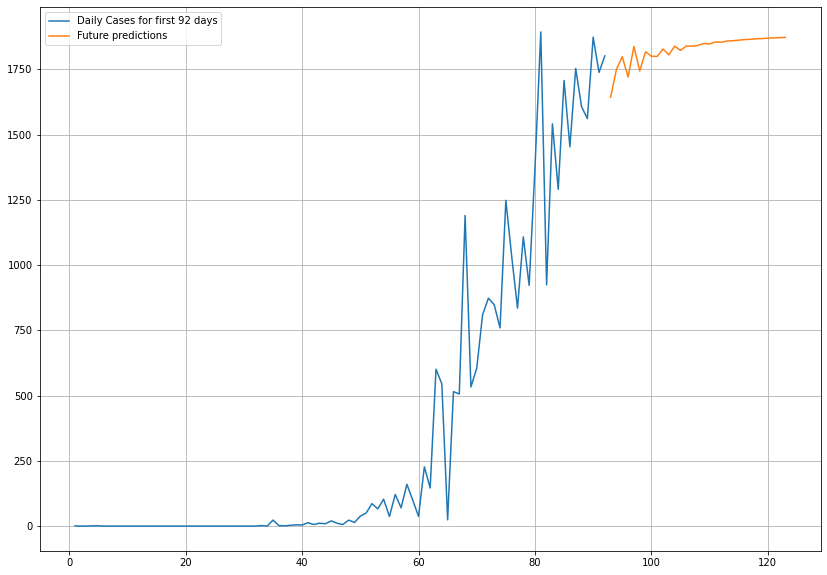

In [102]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Russia


#### Predictions from 10th May to 27th May

In [103]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

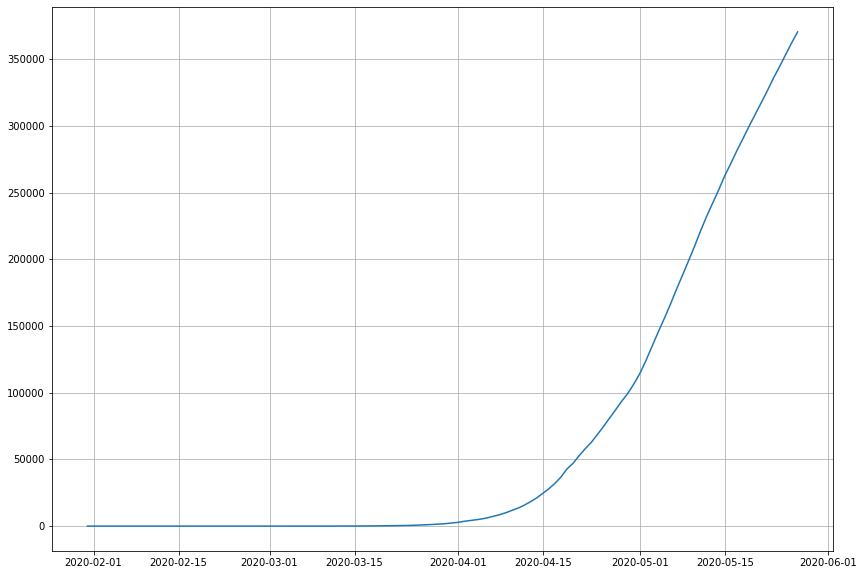

In [104]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

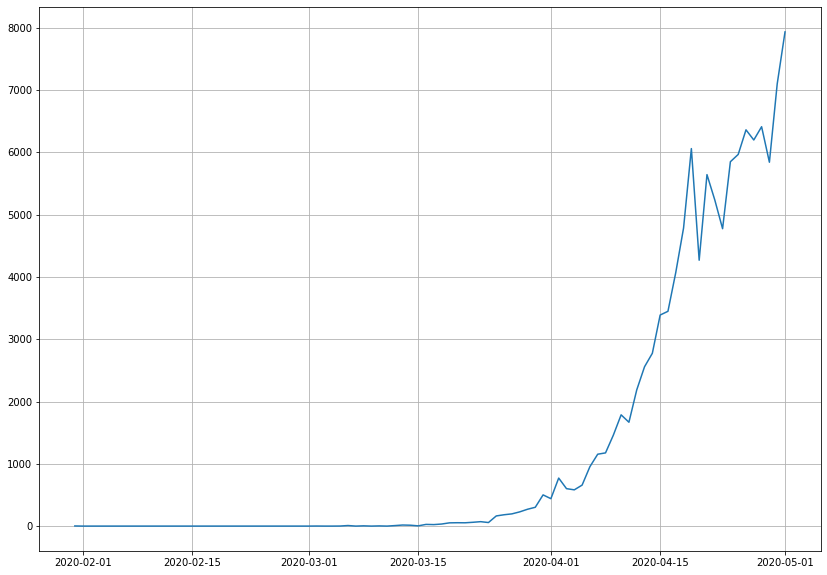

In [105]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

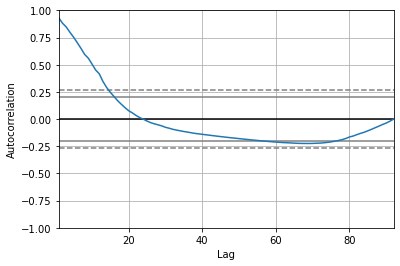

In [106]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [107]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [108]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [109]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [110]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.0017161121573477215 test loss: 0.7476158112287521
Epoch 5 train loss: 0.010060011176994307 test loss: 1.8879046618938446
Epoch 10 train loss: 0.0026987462389359627 test loss: 0.6922152593731881
Epoch 15 train loss: 0.00483511879640333 test loss: 0.7214835301041603
Epoch 20 train loss: 0.0031007639020098686 test loss: 0.13564056428149343
Epoch 25 train loss: 0.0036433236966957197 test loss: 0.43497389405965803
Epoch 30 train loss: 0.002441859710985676 test loss: 0.09385107760026586
Epoch 35 train loss: 0.0030526455188692753 test loss: 0.26482521938160064
Epoch 40 train loss: 0.0022747827165700545 test loss: 0.06003623953583883
Epoch 45 train loss: 0.0026822019362483583 test loss: 0.1613966984092258
Epoch 50 train loss: 0.002082386379719034 test loss: 0.0480578180286102
Epoch 55 train loss: 0.002512846655396489 test loss: 0.10222979109967127
Epoch 60 train loss: 0.0020874567195906793 test loss: 0.05364199592440855
Epoch 65 train loss: 0.002321292241404649 test loss:

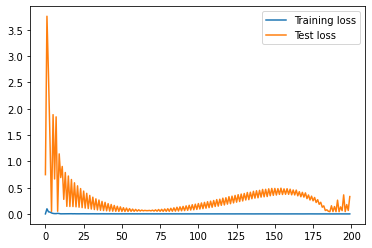

In [111]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [112]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.006931111216545105, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.006924301385879517, 0.007131591439247131, 0.0070593953132629395, 0.006870463490486145, 0.007187694311141968, 0.008923724293708801, 0.008093759417533875, 0.00732971727848053, 0.00796663761138916, 0.007318452000617981, 0.007628247141838074, 0.008444160223007202, 0.011729225516319275, 0.011709704995155334, 0.009218871593475342, 0.013282939791679382, 0.016134142875671387, 0.015994906425476074, 0.022640645503997803, 0.024874478578567505, 0.024713814258

In [113]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 2556 Actual 3388
Predicted 4062 Actual 3448
Predicted 2189 Actual 4070
Predicted 4439 Actual 4785
Predicted 2338 Actual 6060
Predicted 4498 Actual 4268
Predicted 2535 Actual 5642
Predicted 4308 Actual 5236
Predicted 3742 Actual 4774
Predicted 1471 Actual 5849
Predicted 4451 Actual 5965
Predicted 2221 Actual 6361
Predicted 4367 Actual 6198
Predicted 2539 Actual 6411
Predicted 4433 Actual 5841
Predicted 4216 Actual 7099
Predicted 1503 Actual 7933
Train RMSE =  72.61421150601767
Test RMSE =  2856.9710709519477
RMSE Against Pakistan =  1982.431222089802


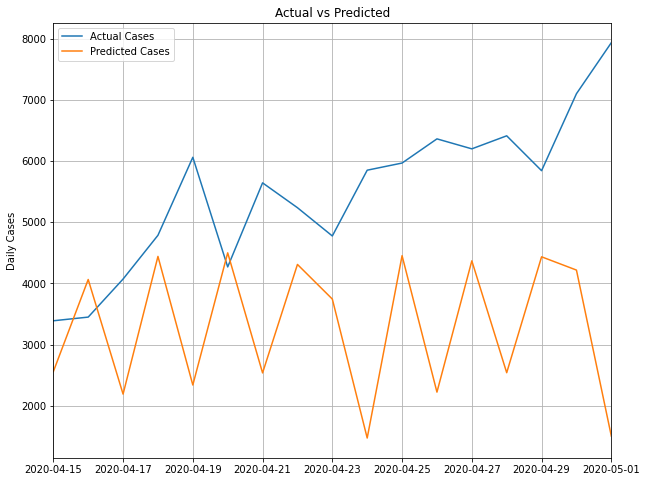

In [114]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

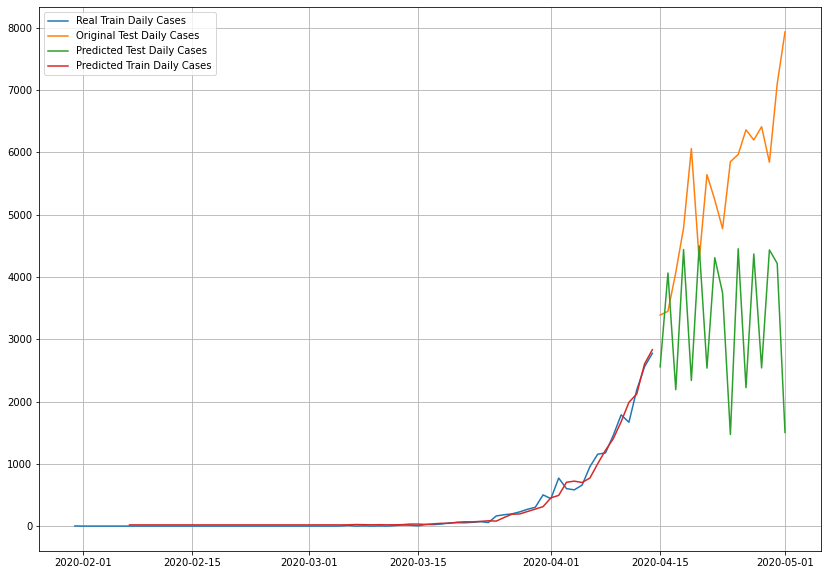

In [115]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

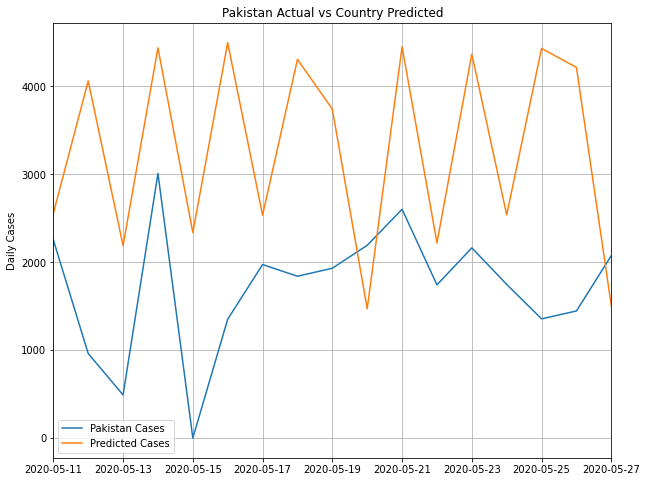

In [116]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [117]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

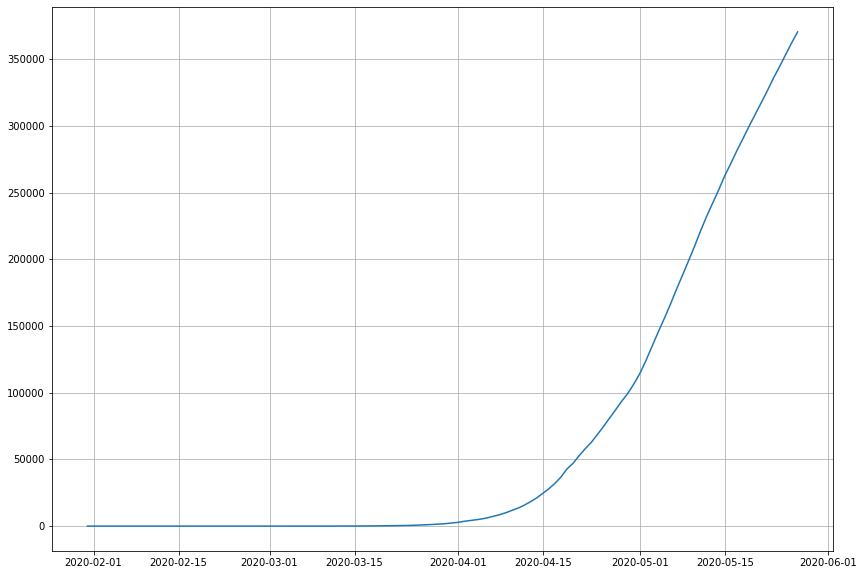

In [118]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

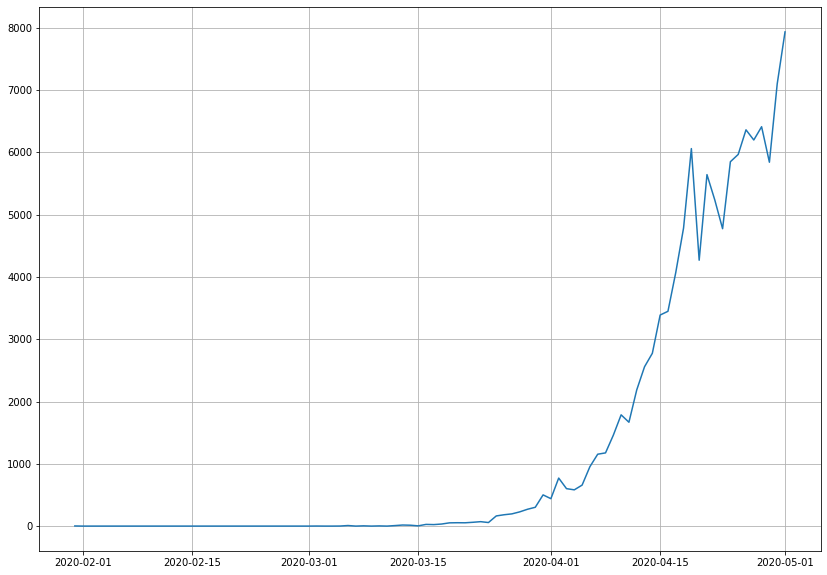

In [119]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

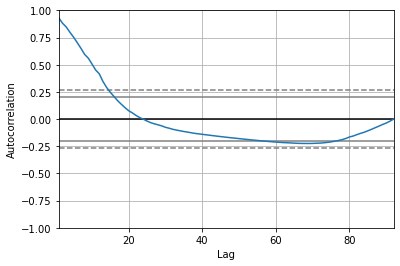

In [120]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [121]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [122]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [123]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [124]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,500,train_seq)

Epoch 0 train loss: 0.0026188823250133746
Epoch 5 train loss: 0.009385449351415954
Epoch 10 train loss: 0.00363479112311195
Epoch 15 train loss: 0.002646857033238147
Epoch 20 train loss: 0.0024907751649967938
Epoch 25 train loss: 0.002454861579028551
Epoch 30 train loss: 0.0024056906916227203
Epoch 35 train loss: 0.002346740032119227
Epoch 40 train loss: 0.0022927522900415007
Epoch 45 train loss: 0.0022425821136414638
Epoch 50 train loss: 0.0021930876128416566
Epoch 55 train loss: 0.0021415247033567905
Epoch 60 train loss: 0.002161955789668497
Epoch 65 train loss: 0.0020247664048839956
Epoch 70 train loss: 0.00202101934532011
Epoch 75 train loss: 0.0020030293497393372
Epoch 80 train loss: 0.0019750823150497462
Epoch 85 train loss: 0.001955252667282223
Epoch 90 train loss: 0.0018805706311764304
Epoch 95 train loss: 0.0018435167149541364
Epoch 100 train loss: 0.0013943107759819262
Epoch 105 train loss: 0.0014153395246492885
Epoch 110 train loss: 0.001491084024492034
Epoch 115 train loss:

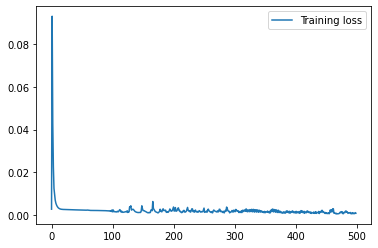

In [125]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [126]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.02385812997817993, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023859739303588867, 0.023918092250823975, 0.02390429377555847, 0.02383631467819214, 0.023915857076644897, 0.024433910846710205, 0.024238795042037964, 0.023879826068878174, 0.024021625518798828, 0.023975223302841187, 0.023987561464309692, 0.024264633655548096, 0.025206387042999268, 0.025263220071792603, 0.02430891990661621, 0.025276154279708862, 0.02641397714614868, 0.026291608810424805, 0.02777719497680664, 0.028649359941482544, 0.02823409438133239

In [127]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  213.79521403406233


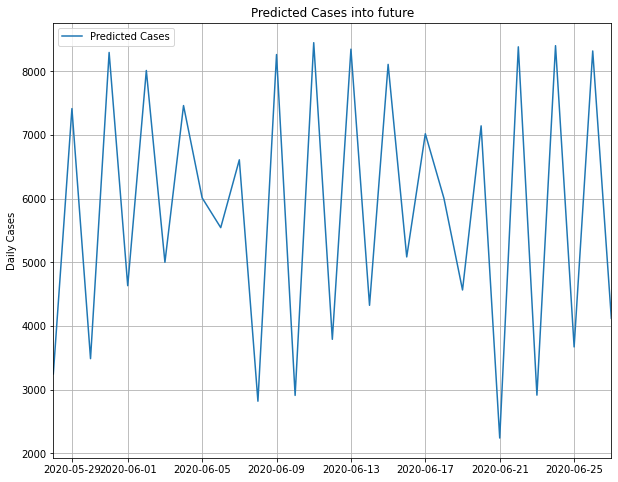

In [128]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

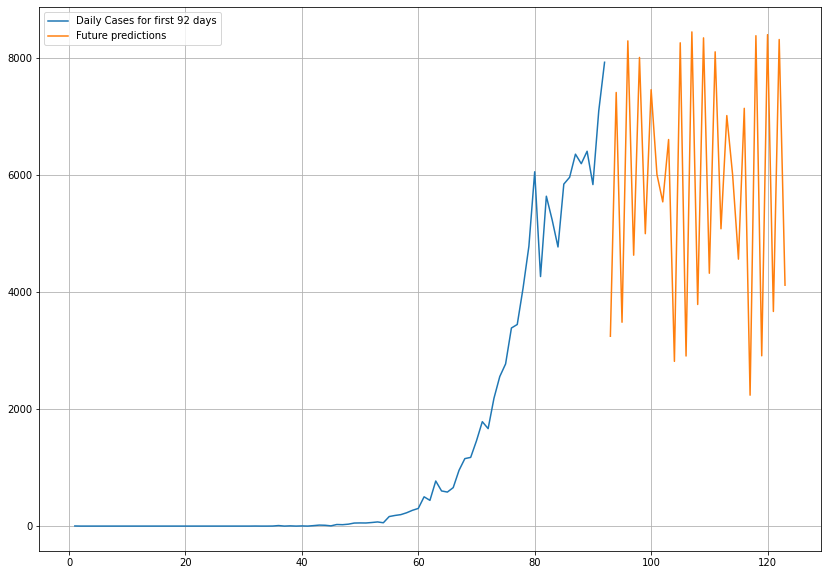

In [129]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Canada


#### Prediction from 10th May to 27th May

In [130]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

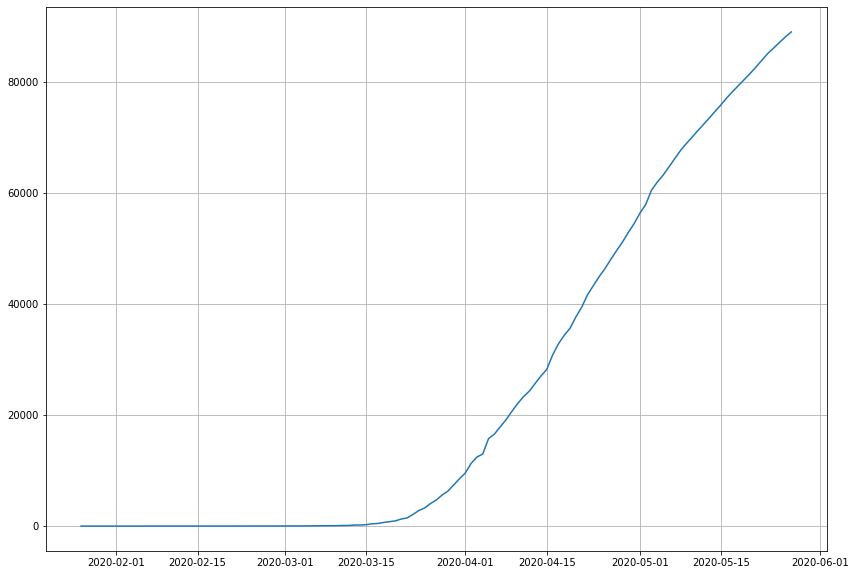

In [131]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

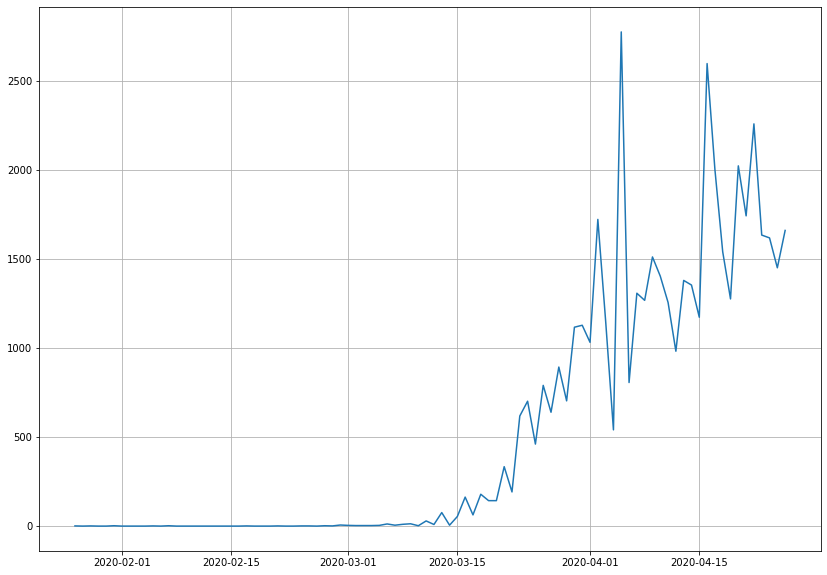

In [132]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

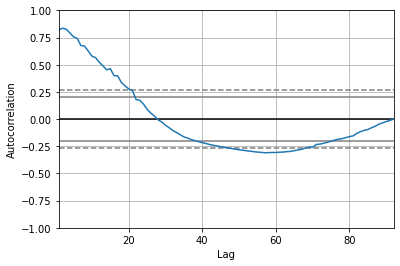

In [133]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 7, as the values are most correalted for that range

In [134]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [135]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [136]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.0004])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor

In [137]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,150,train_seq,test_seq)

Epoch 0 train loss: 0.01235900472175732 test loss: 0.01439852156872803
Epoch 5 train loss: 0.017936551106832475 test loss: 0.02637050792109221
Epoch 10 train loss: 0.012060981946439205 test loss: 0.01898060329258442
Epoch 15 train loss: 0.009939197419486808 test loss: 0.01712822417321149
Epoch 20 train loss: 0.008217433089647423 test loss: 0.023810973005311098
Epoch 25 train loss: 0.00726866353103609 test loss: 0.035050038704139294
Epoch 30 train loss: 0.007571481717784179 test loss: 0.0544517462112708
Epoch 35 train loss: 0.007189789496052508 test loss: 0.0759516547434032
Epoch 40 train loss: 0.006316721542465085 test loss: 0.0879583781119436
Epoch 45 train loss: 0.005562510858148073 test loss: 0.07458830617688364
Epoch 50 train loss: 0.006680724237343155 test loss: 0.09191592535935342
Epoch 55 train loss: 0.005263798374542089 test loss: 0.10047456035390497
Epoch 60 train loss: 0.004642581948741597 test loss: 0.11354567795060574
Epoch 65 train loss: 0.0046238013604645925 test loss: 0.

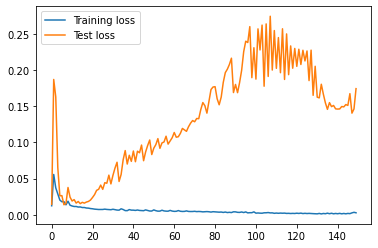

In [138]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [139]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.026310935616493225, 0.025913745164871216, 0.025621622800827026, 0.025800645351409912, 0.026016294956207275, 0.02606312930583954, 0.02615305781364441, 0.026218324899673462, 0.025882795453071594, 0.025647729635238647, 0.025802671909332275, 0.02586263418197632, 0.025810301303863525, 0.025806114077568054, 0.025806114077568054, 0.025806114077568054, 0.0259598046541214, 0.026058852672576904, 0.02584579586982727, 0.025712832808494568, 0.025957077741622925, 0.026087075471878052, 0.025847867131233215, 0.0258665531873703, 0.02620968222618103, 0.026126950979232788, 0.026061877608299255, 0.026369020342826843, 0.027085110545158386, 0.027819886803627014, 0.02742154896259308, 0.026678115129470825, 0.026786774396896362, 0.02717892825603485, 0.02861461043357849, 0.02957361936569214, 0.02879244089126587, 0.029483869671821594, 0.029431313276290894, 0.03067195415496826, 0.03350858390331268, 0.04086709022521973, 0.04390658438205719, 0.03743402659893036, 0.057894498109817505, 0.07868227

In [140]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1325 Actual 1405
Predicted 1148 Actual 1257
Predicted 1623 Actual 983
Predicted 917 Actual 1381
Predicted 1191 Actual 1355
Predicted 1484 Actual 1174
Predicted 1228 Actual 2600
Predicted 1140 Actual 2005
Predicted 1698 Actual 1542
Predicted 1285 Actual 1277
Predicted 627 Actual 2025
Predicted 2099 Actual 1744
Predicted 1591 Actual 2261
Predicted 360 Actual 1636
Predicted 4246 Actual 1620
Predicted 509 Actual 1452
Predicted 1229 Actual 1662
Train RMSE =  96.38306949355035
Test RMSE =  956.2390970793624
RMSE Against Pakistan =  1240.4487073377804


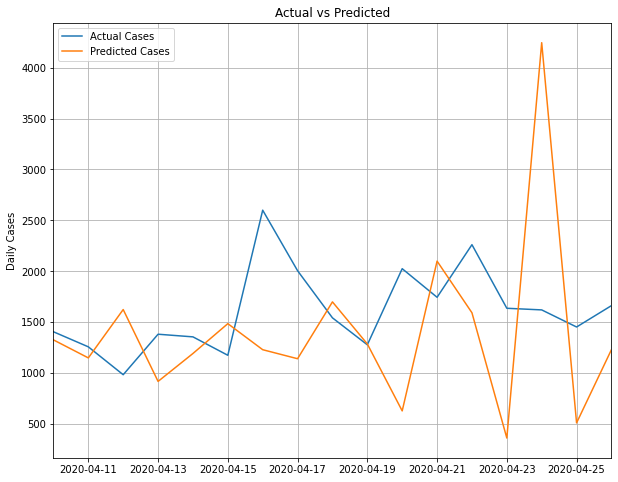

In [141]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

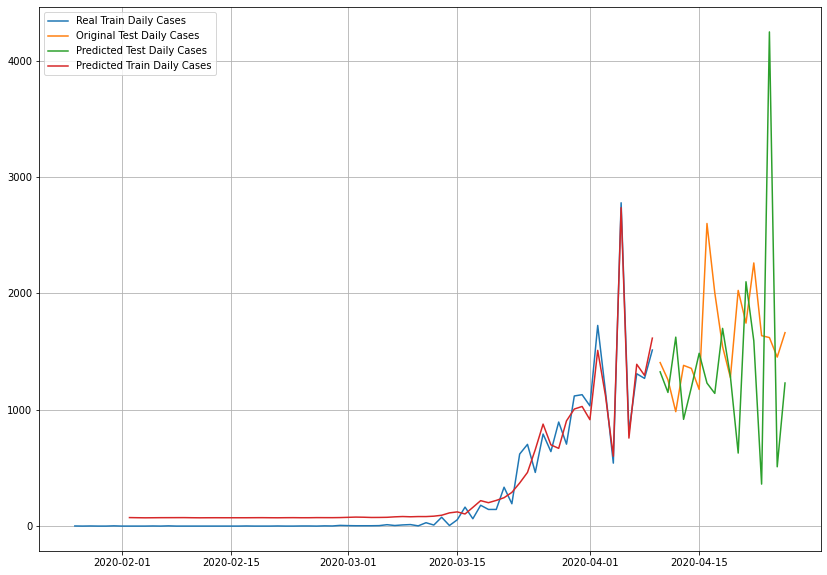

In [142]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

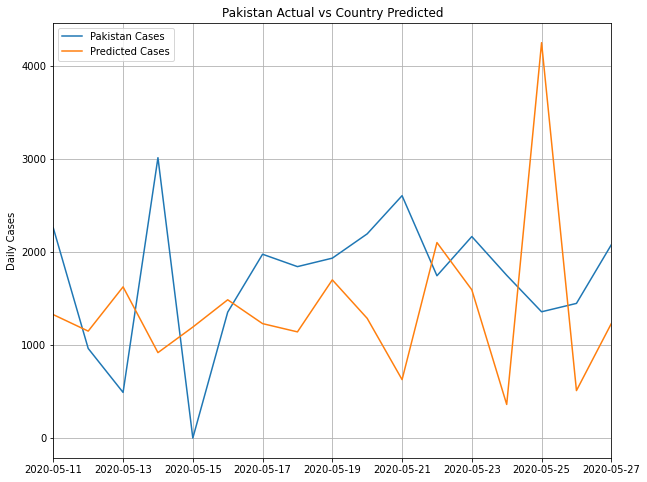

In [143]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [144]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

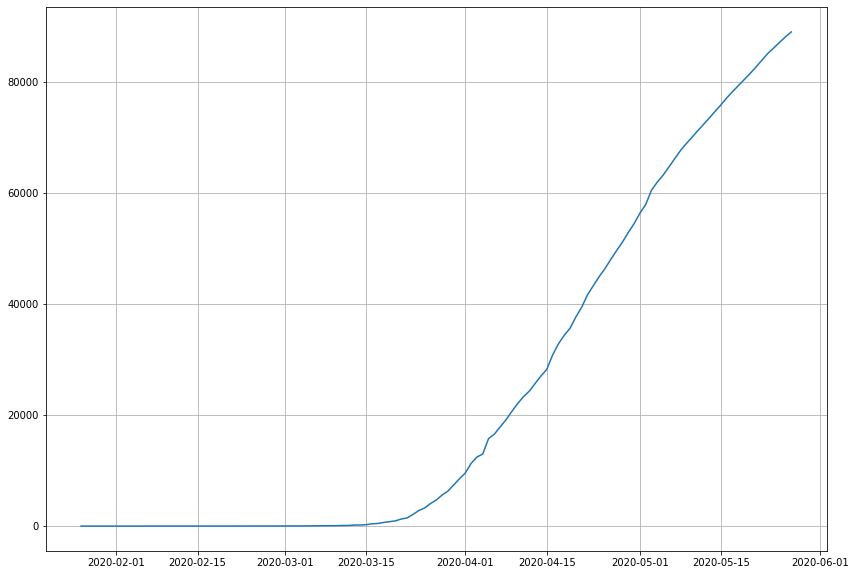

In [145]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

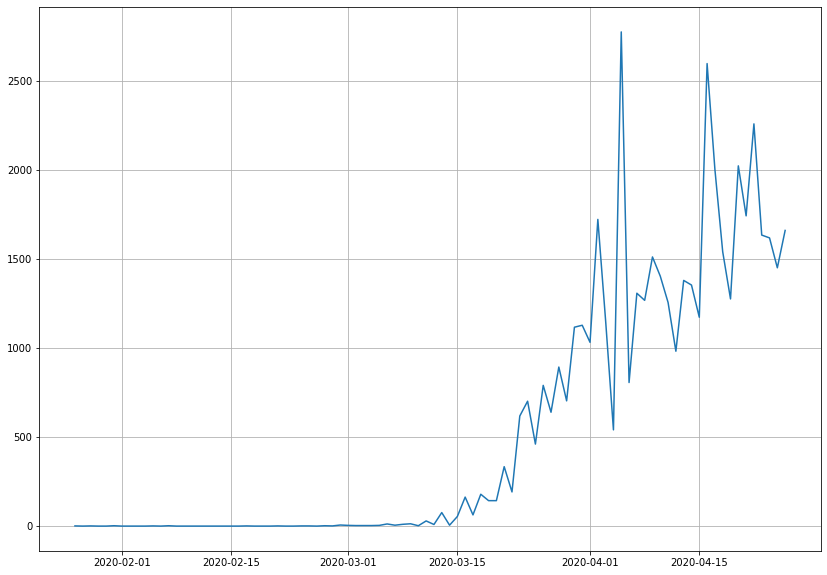

In [146]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

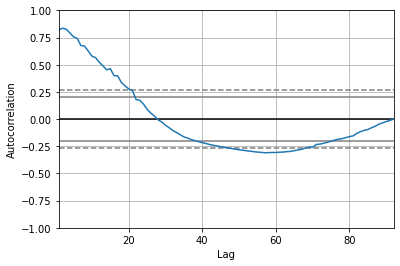

In [147]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 4, as the values are most correalted for that range

In [148]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 4
train_data = daily_cases
print(train_data.shape)

(92,)


In [149]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [150]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000]), tensor([0.0007])), (tensor([0.0004, 0.0000, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.0004])), (tensor([0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.00

In [151]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.01275829566332551
Epoch 5 train loss: 0.021072422627859053
Epoch 10 train loss: 0.014153639323804949
Epoch 15 train loss: 0.012203422908363848
Epoch 20 train loss: 0.011385343883106858
Epoch 25 train loss: 0.011085537036731955
Epoch 30 train loss: 0.010901291674841884
Epoch 35 train loss: 0.010771961128301356
Epoch 40 train loss: 0.010680524625453118
Epoch 45 train loss: 0.010606761767046084
Epoch 50 train loss: 0.010537894500666748
Epoch 55 train loss: 0.010459029543985759
Epoch 60 train loss: 0.010367241224330666
Epoch 65 train loss: 0.01028001487954423
Epoch 70 train loss: 0.010096454088880723
Epoch 75 train loss: 0.010185740309028631
Epoch 80 train loss: 0.009785017472819709
Epoch 85 train loss: 0.009740063249116027
Epoch 90 train loss: 0.009656542199735683
Epoch 95 train loss: 0.009036900873610764
Epoch 100 train loss: 0.009073597531457029
Epoch 105 train loss: 0.008673504345753667
Epoch 110 train loss: 0.00872134192162574
Epoch 115 train loss: 0.009179323502

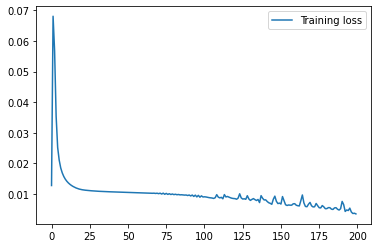

In [152]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [153]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.06962680071592331, 0.06973261386156082, 0.06970511376857758, 0.06973244249820709, 0.06988175213336945, 0.06952259689569473, 0.06958480179309845, 0.06966082751750946, 0.06965866684913635, 0.06988446414470673, 0.06970073282718658, 0.06988175213336945, 0.06952259689569473, 0.06958480179309845, 0.06958480179309845, 0.06958480179309845, 0.06958480179309845, 0.06958480179309845, 0.06958480179309845, 0.06966082751750946, 0.06965866684913635, 0.06973261386156082, 0.06955278664827347, 0.06966082751750946, 0.06965866684913635, 0.06973261386156082, 0.06962893903255463, 0.06973467022180557, 0.06980633735656738, 0.06985118985176086, 0.06977686285972595, 0.07041066139936447, 0.0704151913523674, 0.07096929848194122, 0.07043403387069702, 0.07034735381603241, 0.07045381516218185, 0.07113790512084961, 0.07133567333221436, 0.07237277925014496, 0.07173027098178864, 0.07200263440608978, 0.0735330581665039, 0.07242706418037415, 0.08054932951927185, 0.07642777264118195, 0.087495051324367

In [154]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  193.49960204301422


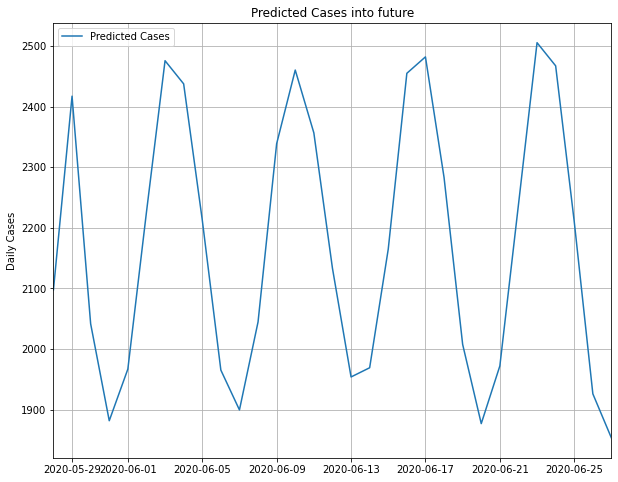

In [155]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

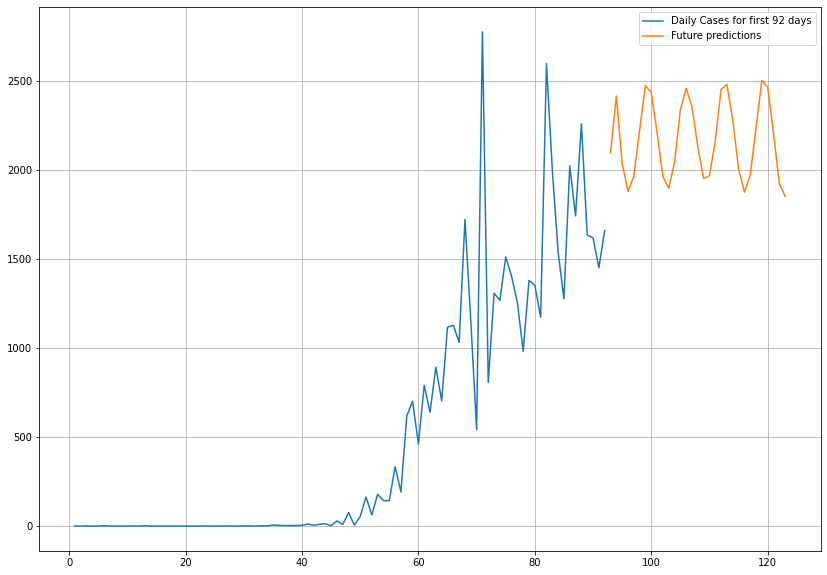

In [156]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Pakistan


#### Prediction from 10th May to 27th May

In [157]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

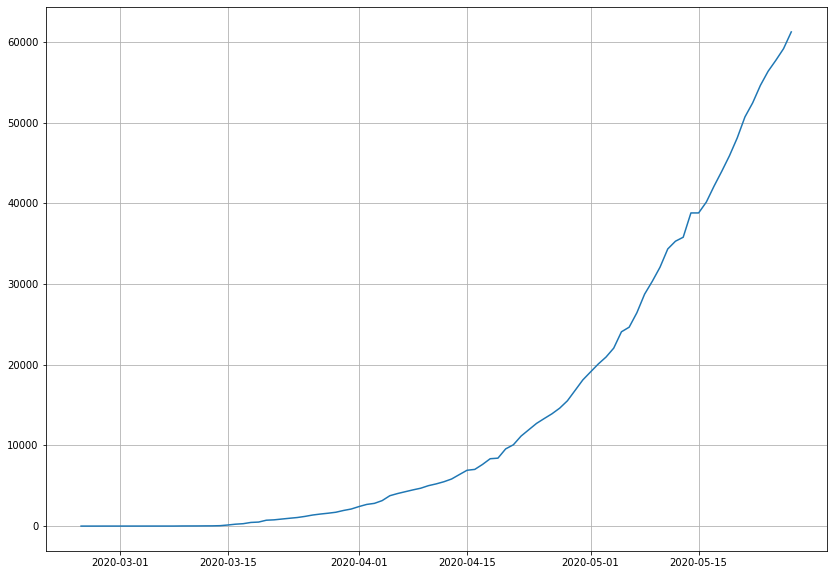

In [158]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

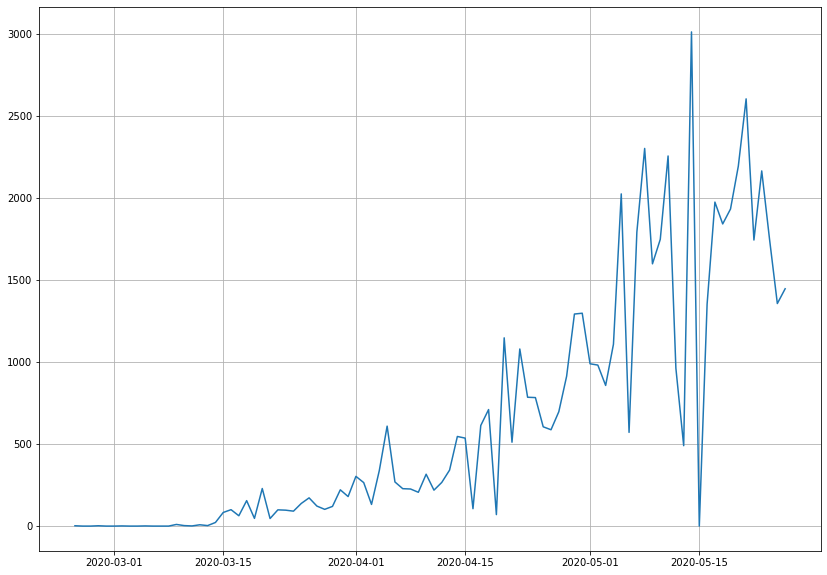

In [159]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

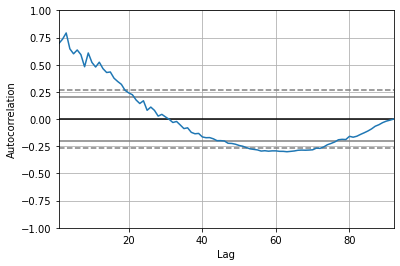

In [160]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 10, as the values are most correalted for that range

In [161]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [162]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [163]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor

In [164]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,300,train_seq,test_seq)

Epoch 0 train loss: 0.007943063749432695 test loss: 0.02615657487185672
Epoch 5 train loss: 0.01760168024111408 test loss: 0.036557885748334226
Epoch 10 train loss: 0.008202342567188619 test loss: 0.12847638903767802
Epoch 15 train loss: 0.007899541863480408 test loss: 0.11357955326475348
Epoch 20 train loss: 0.007832840305011125 test loss: 0.11084530059392819
Epoch 25 train loss: 0.007785020466801531 test loss: 0.11266783188622184
Epoch 30 train loss: 0.007747880303967617 test loss: 0.11792441770408572
Epoch 35 train loss: 0.007718651956789766 test loss: 0.12570324000244
Epoch 40 train loss: 0.007694742152726018 test loss: 0.13463724412395095
Epoch 45 train loss: 0.007672785251821612 test loss: 0.14347194677611697
Epoch 50 train loss: 0.0076500554337060826 test loss: 0.15152642958419166
Epoch 55 train loss: 0.007626289858893308 test loss: 0.15887390602438245
Epoch 60 train loss: 0.007600945438809958 test loss: 0.16881785776349717
Epoch 65 train loss: 0.007556800882662842 test loss: 0.

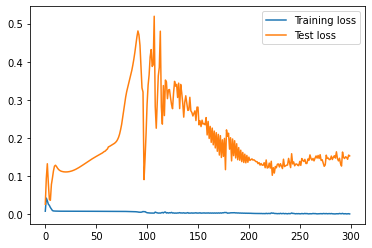

In [165]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [166]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.03753519058227539, 0.03760209679603577, 0.03765886276960373, 0.037527889013290405, 0.0375671312212944, 0.037590838968753815, 0.03746158629655838, 0.038324370980262756, 0.03840816766023636, 0.03827174752950668, 0.03842918574810028, 0.03863818943500519, 0.04081109166145325, 0.045895688235759735, 0.05251184105873108, 0.053940221667289734, 0.06080072373151779, 0.059610143303871155, 0.08820611238479614, 0.06054595112800598, 0.08416569232940674, 0.07012887299060822, 0.07142464816570282, 0.08820407092571259, 0.0738445371389389, 0.07738585770130157, 0.08008363842964172, 0.07748132944107056, 0.09210780262947083, 0.0806959867477417, 0.10748407244682312, 0.09643376618623734, 0.10076284408569336, 0.14458061754703522, 0.11788122355937958, 0.08865521103143692, 0.13424278795719147, 0.10589254647493362, 0.111580990254879, 0.08312572538852692, 0.09172674268484116, 0.13653713464736938, 0.11728527396917343, 0.14126858115196228, 0.11413151025772095, 0.1322019398212433, 0.2538526058197

In [167]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1797 Actual 1747
Predicted 1865 Actual 2255
Predicted 1210 Actual 961
Predicted 825 Actual 490
Predicted 1551 Actual 3011
Predicted 986 Actual 0
Predicted 2068 Actual 1352
Predicted 1840 Actual 1974
Predicted 1630 Actual 1841
Predicted 890 Actual 1932
Predicted 987 Actual 2193
Predicted 938 Actual 2603
Predicted 636 Actual 1743
Predicted 2020 Actual 2164
Predicted 964 Actual 1748
Predicted 659 Actual 1356
Predicted 797 Actual 1446
Train RMSE =  105.50786449300803
Test RMSE =  842.9453637809598
RMSE Against Pakistan =  1049.5760935894466


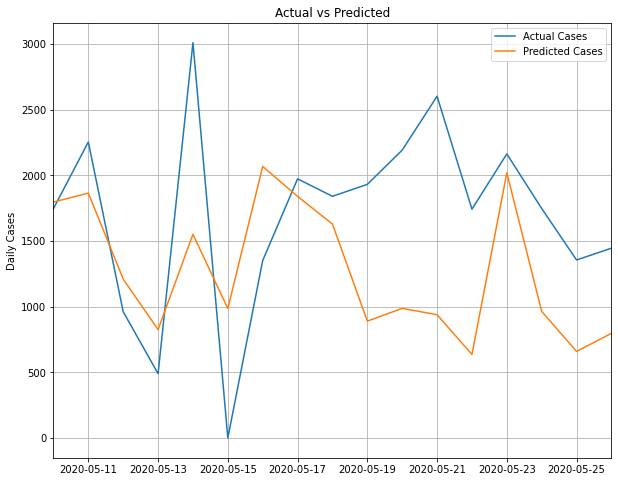

In [168]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

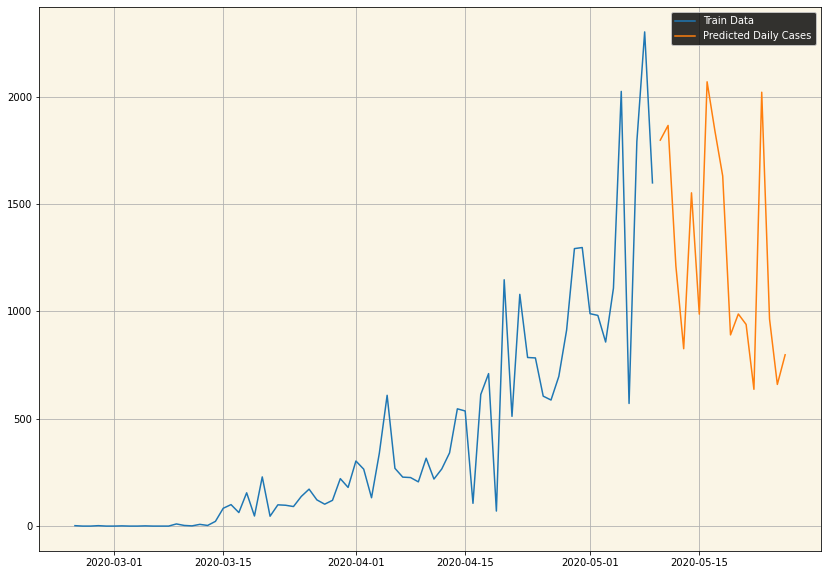

In [169]:
plt.figure(figsize=(14,10))
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('#faf5e6')
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Train Data'
)
# plt.plot(
#   daily_cases.index[len(train_data):len(train_data) + len(real_values)],
#   real_values,
#   label='Original Test Daily Cases'
# )
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Daily Cases'
)
# plt.plot(
#   daily_cases.index[WINDOW_SIZE:len(train_data)],
#   train_pred,
#   label='Predicted Train Daily Cases'
# )
leg = plt.legend(facecolor='black', framealpha=0.8)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.savefig("pakistan_cases_forcast.png")

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [170]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     697.0
4/28/20     913.0
4/29/20    1292.0
4/30/20    1297.0
5/1/20      989.0
5/2/20      981.0
5/3/20      857.0
5/4/20     1108.0
5/5/20     2024.0
5/6/20      571.0
5/7/20     1791.0
5/8/20     2301.0
5/9/20     1598.0
5/10/20    1747.0
5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

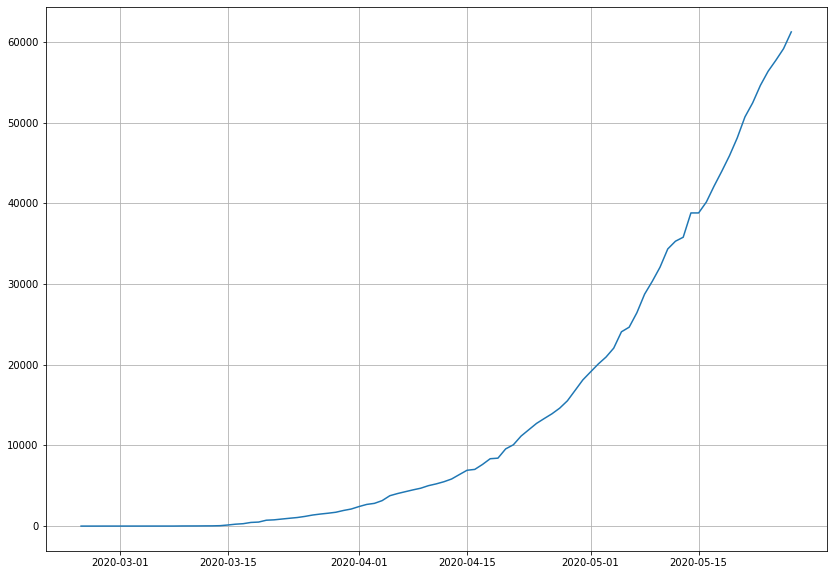

In [171]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

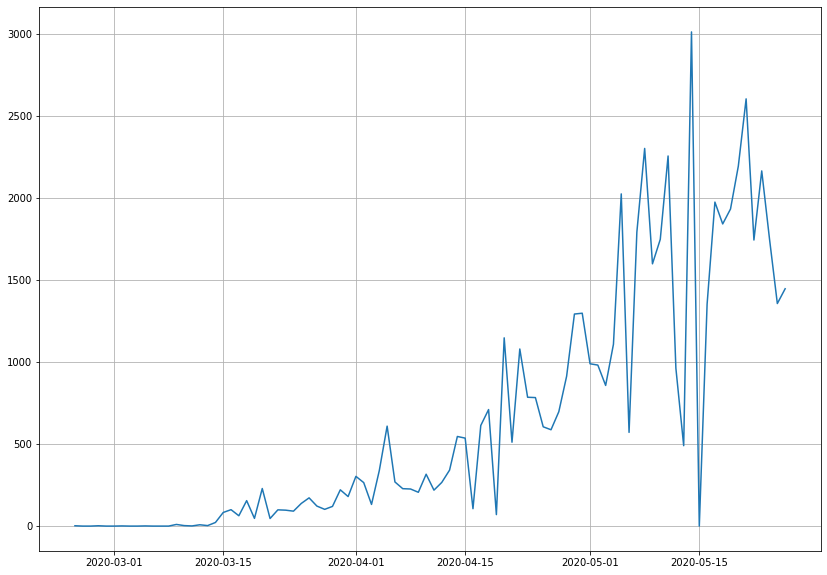

In [172]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

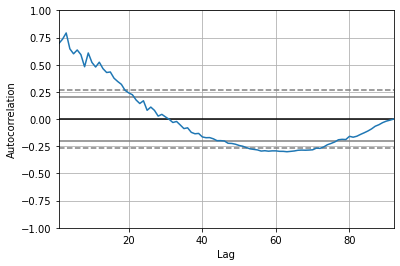

In [173]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 5, as the values are most correalted for that range

In [174]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
train_data = daily_cases
print(train_data.shape)

(92,)


In [175]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [176]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor([0.0073])), (tensor([0.0010, 0.0003, 0.0027, 0.0010, 0.

In [177]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,300,train_seq)

Epoch 0 train loss: 0.01942117126210288
Epoch 5 train loss: 0.030249818119675663
Epoch 10 train loss: 0.020172694009837594
Epoch 15 train loss: 0.016350880467292692
Epoch 20 train loss: 0.015326294595503906
Epoch 25 train loss: 0.015409196190026665
Epoch 30 train loss: 0.014434005962268473
Epoch 35 train loss: 0.013933207251378416
Epoch 40 train loss: 0.013314528768396358
Epoch 45 train loss: 0.012976946696634012
Epoch 50 train loss: 0.012145746163737356
Epoch 55 train loss: 0.011468399375842993
Epoch 60 train loss: 0.010586690686367568
Epoch 65 train loss: 0.009883181877954804
Epoch 70 train loss: 0.009313271226940534
Epoch 75 train loss: 0.00880144606977912
Epoch 80 train loss: 0.008350437990685904
Epoch 85 train loss: 0.008054389595086236
Epoch 90 train loss: 0.0077662192148380965
Epoch 95 train loss: 0.01062854451354975
Epoch 100 train loss: 0.006999725607352178
Epoch 105 train loss: 0.006802246770152563
Epoch 110 train loss: 0.007703006112309701
Epoch 115 train loss: 0.00837992620

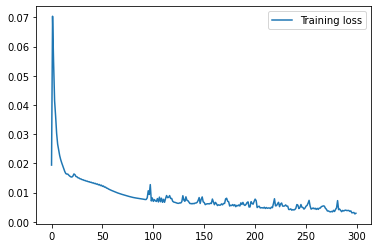

In [178]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [179]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.026570692658424377, -0.026493564248085022, -0.026242747902870178, -0.026590600609779358, -0.026622459292411804, -0.02645067870616913, -0.026661589741706848, -0.026622459292411804, -0.02654390037059784, -0.02575056254863739, -0.026274189352989197, -0.025314852595329285, -0.023516878485679626, -0.024843022227287292, -0.02319277822971344, -0.016565963625907898, -0.011339232325553894, -0.0031667202711105347, 0.019999369978904724, 0.015476539731025696, 0.037275493144989014, 0.015615105628967285, 0.038995400071144104, 0.02188447117805481, 0.0336228609085083, 0.023423030972480774, 0.032102882862091064, 0.03519006073474884, 0.04309171438217163, 0.04842379689216614, 0.05020301043987274, 0.044618844985961914, 0.06776735186576843, 0.07316185534000397, 0.09903521835803986, 0.11481891572475433, 0.12274295091629028, 0.17650562524795532, 0.13213297724723816, 0.10152198374271393, 0.16094177961349487, 0.1119488924741745, 0.09695279598236084, 0.11258020997047424, 0.1055693775415420

In [180]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  136.96252038907954


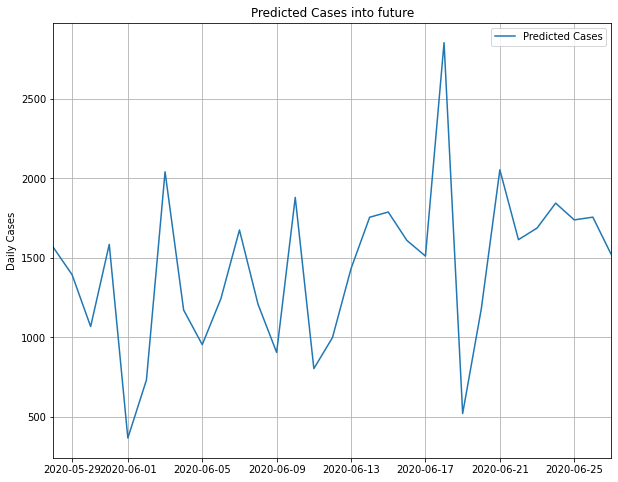

In [181]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

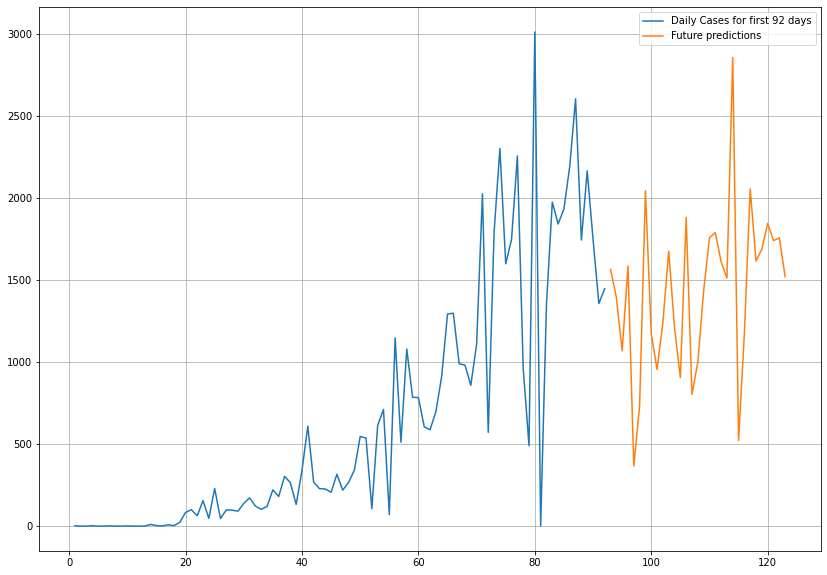

In [182]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

## Approach 2 (LSTM, trained on stationary series)

In [183]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    2255.0
5/12/20     962.0
5/13/20     490.0
5/14/20    3011.0
5/15/20       0.0
5/16/20    1352.0
5/17/20    1974.0
5/18/20    1841.0
5/19/20    1932.0
5/20/20    2193.0
5/21/20    2603.0
5/22/20    1743.0
5/23/20    2164.0
5/24/20    1748.0
5/25/20    1356.0
5/26/20    1446.0
5/27/20    2076.0
dtype: float64

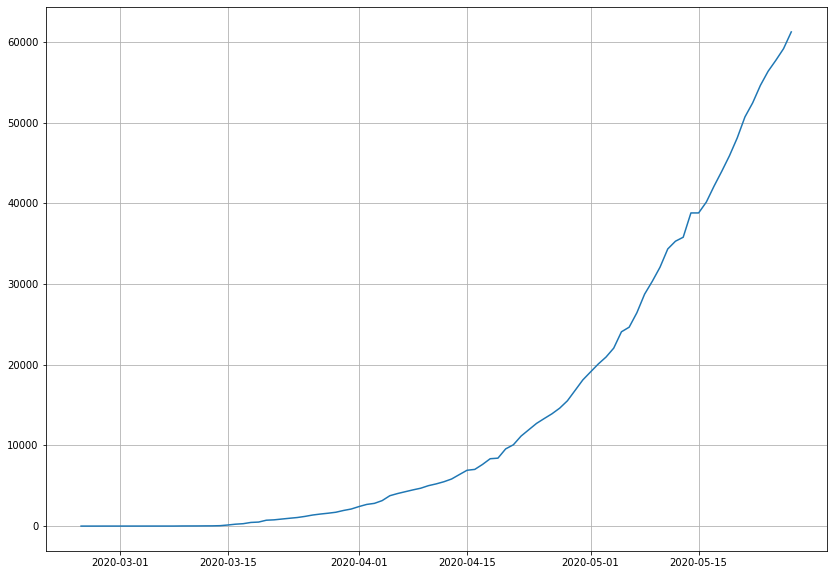

In [184]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

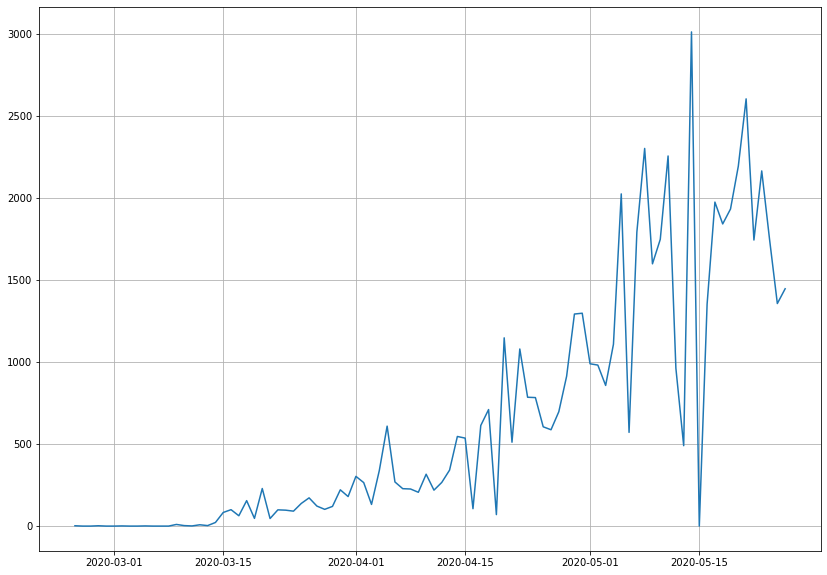

In [185]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

In [186]:
def makeSeriesStationary(series):
    abc = series - series.shift()
    abc.fillna(0,inplace = True)
    return abc
def reverseStationarySeries(series,start,index):
    abc = pd.Series(series, copy=True)
    abc_cumsum = abc.cumsum()
    temp = pd.Series(start,index)
    temp = temp.add(abc_cumsum,fill_value=0)
    return temp

def reverseStationarySeries3(series,start):
    abc = pd.Series(series)
    for x in range(1,len(abc)):
      abc[x] = abc[x] + abc[x-1]
    for x in range(len(abc)):
      abc[x] = abc[x] + start
    abc = pd.Series(abc)
    return abc

def compare(sr1, sr2):
  diff = 0
  for x,y in enumerate(sr1):
    diff += abs(y) - abs(sr2[x])
  return diff

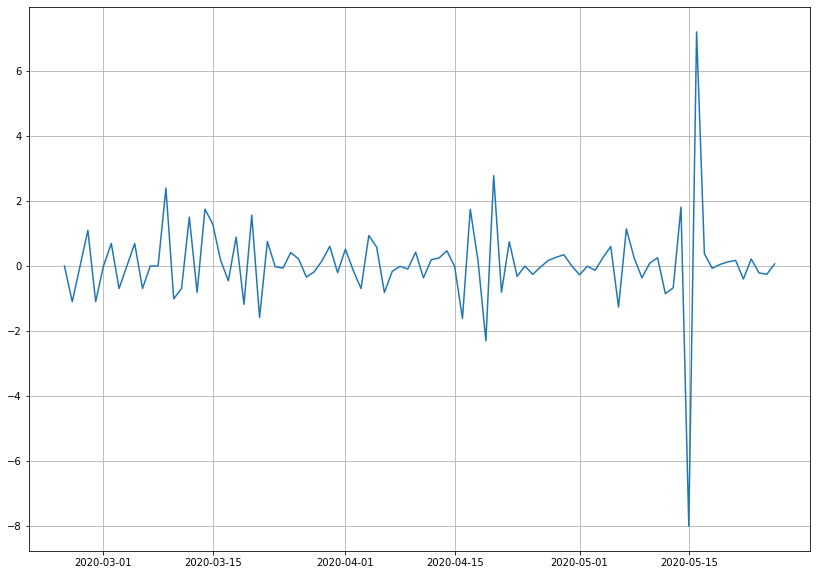

In [187]:
daily_cases_log = np.log(daily_cases + 1)
daily_cases2 = makeSeriesStationary(daily_cases_log)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases2)

2020-02-25       2.0
2020-02-26       0.0
2020-02-27       0.0
2020-02-28       2.0
2020-02-29       0.0
               ...  
2020-05-22    1743.0
2020-05-23    2164.0
2020-05-24    1748.0
2020-05-25    1356.0
2020-05-26    1446.0
Length: 92, dtype: float64
2020-02-25      0.0
2020-02-26     -2.0
2020-02-27      0.0
2020-02-28      2.0
2020-02-29     -2.0
              ...  
2020-05-22   -860.0
2020-05-23    421.0
2020-05-24   -416.0
2020-05-25   -392.0
2020-05-26     90.0
Length: 92, dtype: float64


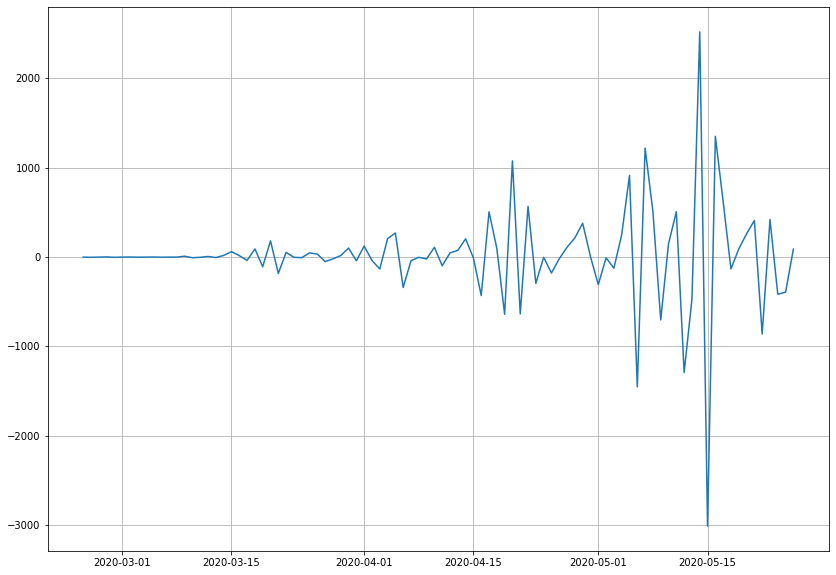

In [188]:
print(daily_cases)
daily_cases2 = makeSeriesStationary(daily_cases)
print(daily_cases2)
daily_cases3 = reverseStationarySeries(daily_cases2,daily_cases[0],daily_cases.index)
# print(daily_cases3)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases2)

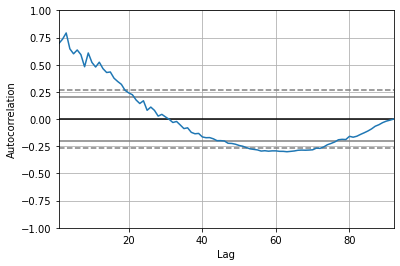

In [189]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 6, as the values are most correalted for that range

In [190]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
# daily_cases = makeSeriesStationary(daily_cases)
WINDOW_SIZE = 6
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
# train_data_log = np.log(train_data + 1)
# test_data_log = np.log(test_data + 1)
train_data_stat = makeSeriesStationary(train_data)
test_data_stat = makeSeriesStationary(test_data)
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [191]:
scaler = MinMaxScaler((-1,1))
train_data_normalized = scaler.fit_transform(train_data_stat.values.reshape(-1,1))
test_data_normalized = scaler.fit_transform(test_data_stat.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [192]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0872, 0.0857, 0.0872, 0.0887, 0.0857, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0887, 0.0857, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0887, 0.0857, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0887, 0.0857, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0879, 0.0864, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0879, 0.0864, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0872])), (tensor([0.0864, 0.0872, 0.0879, 0.0864, 0.0872, 0.0872]), tensor([0.0947])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0872, 0.0947]), tensor([0.0819])), (tensor([0.0879, 0.0864, 0.0872, 0.0872, 0.0947, 0.0819]), tensor([0.0857])), (tensor([0.0864, 0.0872, 0.0872, 0.0947, 0.0819, 0.0857]), tensor([0.0924])), (tensor([0.0872, 0.0872, 0.0947, 0.0819, 0.0857, 0.0924]), tensor([0.0834])), (tensor([0.0872, 0.0947, 0.0819, 0.0857, 0.0924, 0.0834]), tens

In [193]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.06987250893704793 test loss: 0.03887369716027355
Epoch 5 train loss: 0.04815215471933985 test loss: 0.026160614406266672
Epoch 10 train loss: 0.035194759104168014 test loss: 0.04607911375007296
Epoch 15 train loss: 0.031661892783341646 test loss: 0.06764643077622168
Epoch 20 train loss: 0.03002004183908405 test loss: 0.09206314566968517
Epoch 25 train loss: 0.02866874123793568 test loss: 0.12637309543788433
Epoch 30 train loss: 0.0277177862662094 test loss: 0.16614531937309288
Epoch 35 train loss: 0.027256548485085026 test loss: 0.19279922261326152
Epoch 40 train loss: 0.026532928499179525 test loss: 0.2217491507630753
Epoch 45 train loss: 0.024822382104560715 test loss: 0.30513727340902813
Epoch 50 train loss: 0.029525103756368742 test loss: 0.22354425067367795
Epoch 55 train loss: 0.02153801692340817 test loss: 0.31192798807949823
Epoch 60 train loss: 0.01946148524327815 test loss: 0.25759686599485576
Epoch 65 train loss: 0.019111682574986476 test loss: 0.241164

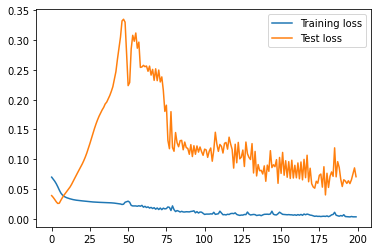

In [194]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [195]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.11216182261705399, 0.11242473125457764, 0.11118431389331818, 0.11058810353279114, 0.11209093034267426, 0.11129365861415863, 0.11138887703418732, 0.11220178008079529, 0.10627404600381851, 0.10860531032085419, 0.1184052973985672, 0.11336669325828552, 0.11045708507299423, 0.09819426387548447, 0.07388298213481903, 0.07297157496213913, 0.13660438358783722, 0.12054462730884552, 0.16876721382141113, 0.11656327545642853, 0.12798486649990082, 0.15856871008872986, 0.1279202699661255, 0.16510124504566193, 0.04926655441522598, 0.12197577953338623, 0.09154347330331802, 0.1629742532968521, 0.1803395301103592, 0.06180862337350845, 0.03927450627088547, 0.12632052600383759, 0.13917580246925354, 0.22159266471862793, 0.2530747354030609, -0.11402192711830139, 0.06389303505420685, 0.15768064558506012, 0.10342147946357727, 0.1744113564491272, 0.01521824300289154, 0.14816531538963318, 0.1753527820110321, 0.09590451419353485, -0.010813713073730469, -0.09635615348815918, 0.4298458695411682

In [196]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))

In [197]:
train_idx = daily_cases.index[WINDOW_SIZE:len(train_pred)+WINDOW_SIZE]
train_pred2 = reverseStationarySeries3(train_pred.flatten(),train_data[WINDOW_SIZE])
# train_pred2 = reverseStationarySeries3(train_pred.flatten(),train_data_log[WINDOW_SIZE])
# train_pred2 = np.exp(train_pred2)
print(train_pred2)

0       66.239601
1      132.206408
2      194.742220
3      255.628915
4      320.672428
         ...     
64    7932.342347
65    4945.719170
66    7494.696677
67    8492.061310
68    7051.104851
Length: 69, dtype: float64


In [198]:
test_idx = daily_cases.index[len(train_data):]
actual_predictions2 = reverseStationarySeries3(actual_predictions.flatten(),test_data[0])
# actual_predictions2 = reverseStationarySeries3(actual_predictions.flatten(),test_data_log[0])
# actual_predictions2 = np.exp(actual_predictions2)
print(actual_predictions2)

0     3754.108645
1     3263.590645
2     3395.233237
3     2513.135455
4     3164.629737
5     2595.014379
6     1974.697065
7     1921.733235
8     1583.306387
9     2168.339212
10    1827.130737
11     179.538338
12    2880.673397
13    1254.702655
14     367.186950
15    1022.644291
16     -26.989868
dtype: float64


In [199]:
real_values2 = reverseStationarySeries3(real_values.flatten(),test_data[0])
# real_values2 = reverseStationarySeries3(real_values.flatten(),test_data_log[0])
# real_values2 = np.exp(real_values2) - 1
print(real_values2)
print(compare(real_values2,test_data))

0     1747.000000
1     2255.000000
2      961.999878
3      489.999878
4     3011.000000
5       -0.000122
6     1351.999756
7     1973.999756
8     1840.999756
9     1931.999756
10    2192.999756
11    2602.999756
12    1742.999756
13    2163.999756
14    1747.999756
15    1355.999756
16    1445.999756
dtype: float32
-0.0028076171875


In [200]:
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions2[x]),"Actual",int(real_values2[x]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred2))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values2,actual_predictions2))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions2))
print("RMSE Against Pakistan = ",pak_rms)

Test cases prediction
Predicted 3754 Actual 1747
Predicted 3263 Actual 2255
Predicted 3395 Actual 961
Predicted 2513 Actual 489
Predicted 3164 Actual 3011
Predicted 2595 Actual 0
Predicted 1974 Actual 1351
Predicted 1921 Actual 1973
Predicted 1583 Actual 1840
Predicted 2168 Actual 1931
Predicted 1827 Actual 2192
Predicted 179 Actual 2602
Predicted 2880 Actual 1742
Predicted 1254 Actual 2163
Predicted 367 Actual 1747
Predicted 1022 Actual 1355
Predicted -26 Actual 1445
Train RMSE =  2779.93190656109
Test RMSE =  1427.575214077876
RMSE Against Pakistan =  1481.3442135451498


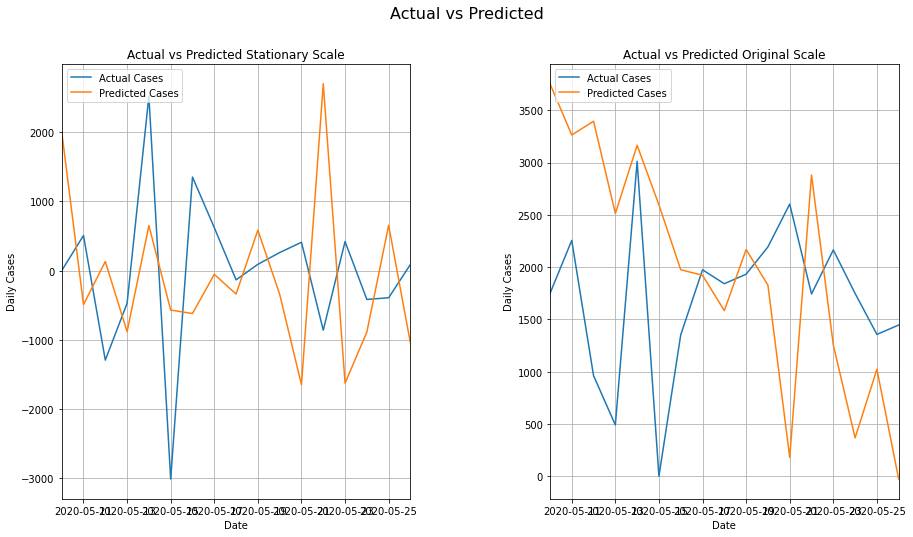

In [201]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].set_title('Actual vs Predicted Stationary Scale')
axs[0].grid(True)
axs[0].autoscale(axis='x', tight=True)
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
axs[0].legend(loc='upper left')
axs[1].grid(True)
axs[1].autoscale(axis='x', tight=True)
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values2,label = "Actual Cases")
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions2, label = "Predicted Cases")
axs[1].set_title('Actual vs Predicted Original Scale')
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

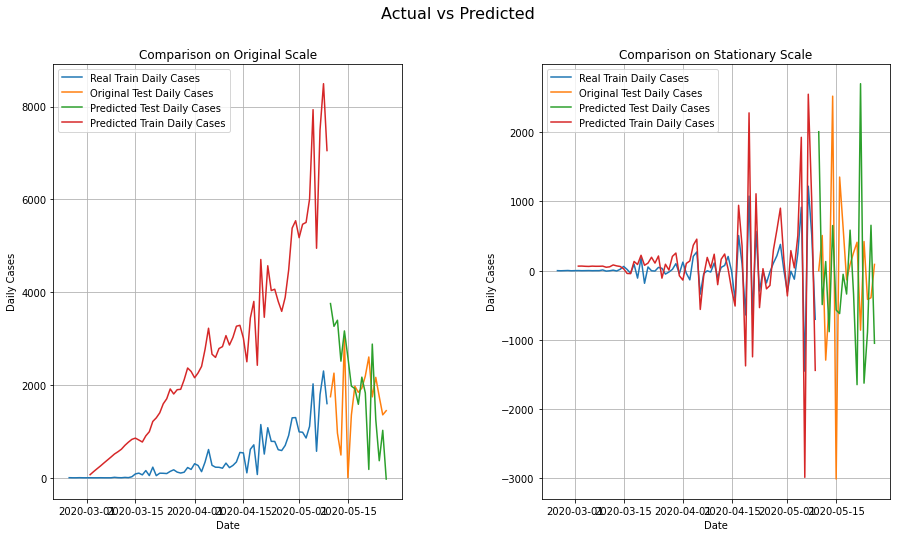

In [202]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].grid(True)
axs[0].plot(
  daily_cases.index[:len(train_data)],
  # train_data_stat.values,
  train_data,
  label='Real Train Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values2,
  label='Original Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions2,
  label='Predicted Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred2,
  label='Predicted Train Daily Cases'
)
axs[0].set_title("Comparison on Original Scale")
axs[0].legend(loc='upper left')

axs[1].grid(True)
axs[1].plot(
  daily_cases.index[:len(train_data)],
  train_data_stat.values,
  label='Real Train Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
axs[1].set_title("Comparison on Stationary Scale")
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

This approach is definitely a better approach capable of giving extremely accurate results, with less risk of overfitting. However i was unable to solve a critical problem after continuous struggle.   
The problem lies in casting the predictions back to the non-stationary scale.The predicted and actual lines look much alike, however it can be seen in the graph above that test predictions though similar in shape to actual cases, are on an incline.    
If you notice the graph of the right, the initial red predictions values lie little bit above the blue real values, this error in the inital terms, gets multiplied and propogated to other values as we go back to original scale (since making a series is differentiating, and reverting is integegration which sums up the erros as well).  
This is the approach i was going for in this project originally, but after continuous tries, i was unable to reduce my error for the initial prediction, even a log transform fails to help.If the error can be reduced, the reverted predictions will be much accurate.    
The code and graphs have been left, just for exhibition purposes only. :-)


# Results for Approach 1

## Train RMSE

Following rmse are what were reported during training phase of model, for predictions between 10th May and 27th May

In [203]:
for country in train_rmse.keys():
  print(country,train_rmse[country])

Belgium 125.43027451914617
Sweden 37.37785827729104
India 82.3843801282539
Russia 72.61421150601767
Canada 96.38306949355035
Pakistan 105.50786449300803


## Test RMSE

Following rmse are what were reported during testing phase of model, for predictions between 10th May and 27th May

In [204]:
for country in test_rmse.keys():
  print(country,test_rmse[country])

Belgium 813.6752076460521
Sweden 191.8205366441506
India 641.0777425493661
Russia 2856.9710709519477
Canada 956.2390970793624
Pakistan 842.9453637809598


## Pakistan RMSE

Following rmse are computed by comparing predictions between 10th May and 27th May with Pakistan

In [205]:
for country in pak_rmse.keys():
  print(country,pak_rmse[country])

Belgium 888.8772820381846
Sweden 1423.7789129209366
India 1068.9983757005311
Russia 1982.431222089802
Canada 1240.4487073377804
Pakistan 1049.5760935894466


We can see that Belgium was very successul in predicting future cases for Pakistan, as well as Pakistan itself. India also gives good enough results   
The reason other countries were not able to give good results is because of their scale of cases is different than Pakistan.However their performance is good against their own cases. These countires can be classified as bad picks for predicting cases for pakistan. But they were not discarded, so as to stay consistent with the criteria of picking countries

## Prediction Comaprison (10th May to 27th May)

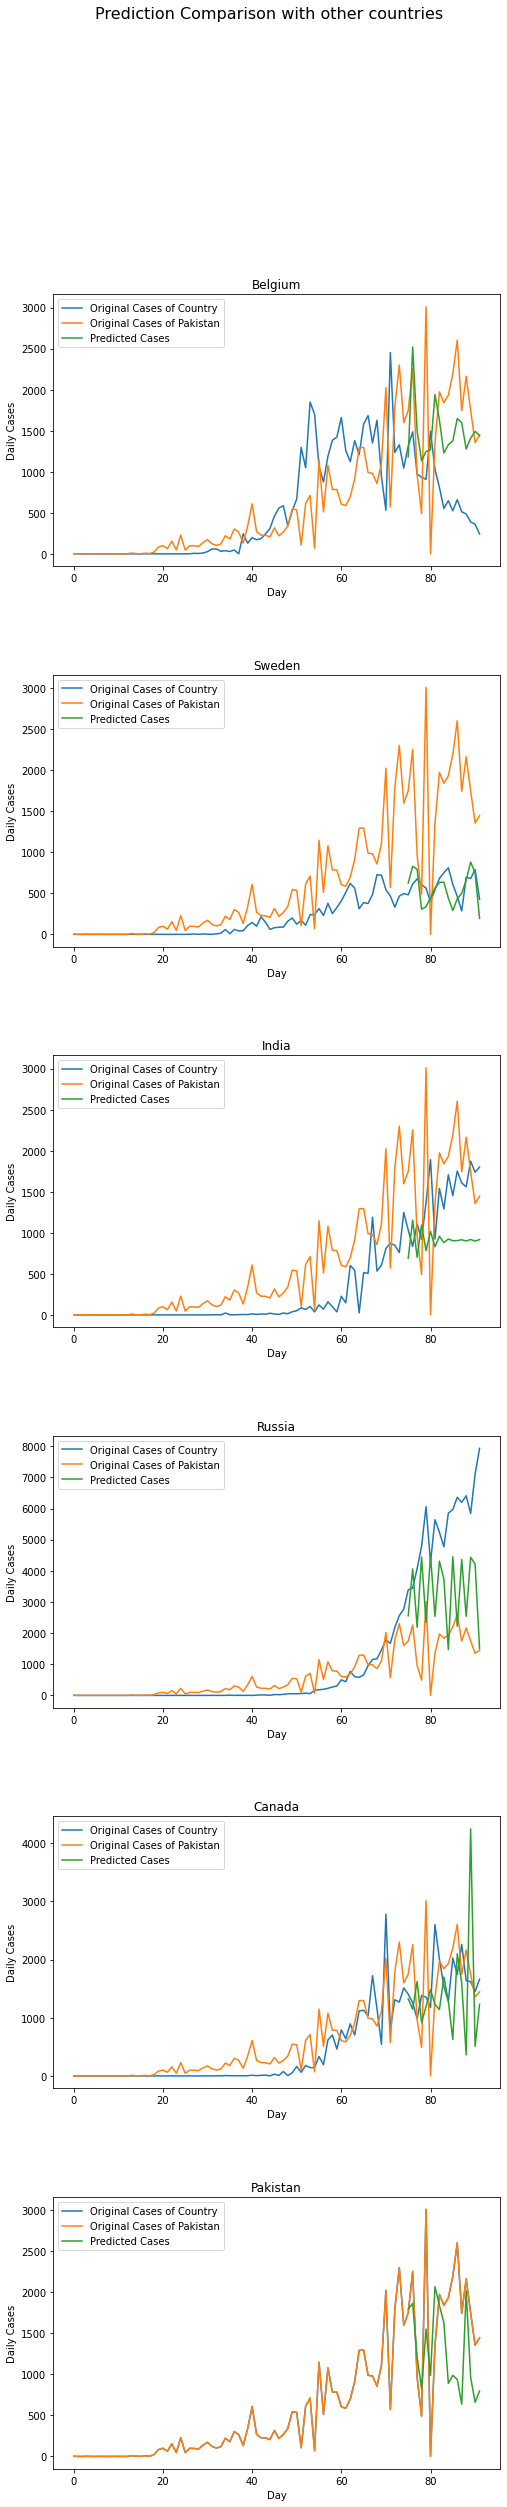

In [206]:
days = [x for x in range(92)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days,country_series[:len(days)], label = "Original Cases of Country")
    axs[i].plot(days,pak_series[:-1], label = "Original Cases of Pakistan")
    axs[i].plot(days[-17:],pred_trend[country], label = "Predicted Cases")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

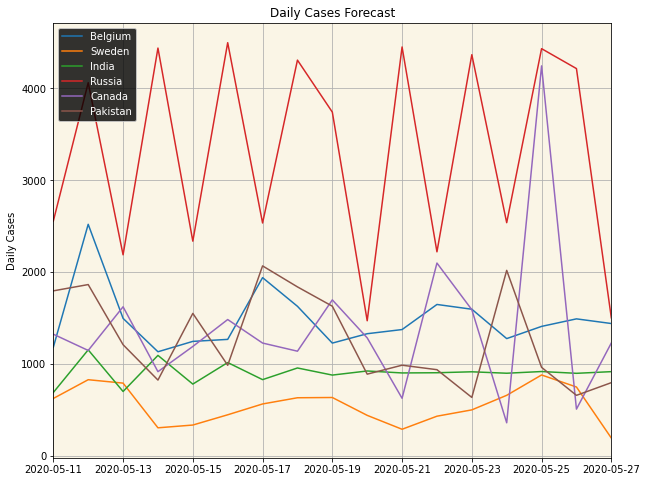

In [207]:
# pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
# plt.figure(figsize=(10,8))
# plt.title('Pakistan Actual vs Country Predicted')
# plt.ylabel('Daily Cases')
# plt.grid(True)
# plt.autoscale(axis='x', tight=True)
# index = pd.date_range(start="2020-05-11",end="2020-05-27")
# plt.plot(index,pak_series[-17:],label = "Pakistan Original Cases")
# for country in pred_trend.keys():
#   plt.plot(index,pred_trend[country], label = country+" Predicted Cases")
# plt.legend();



pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
plt.figure(figsize=(10,8))
plt.title('Daily Cases Forecast')
plt.ylabel('Daily Cases')
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('#faf5e6')
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
for country in pred_trend.keys():
  plt.plot(index,pred_trend[country], label = country)
leg = plt.legend(facecolor='black', framealpha=0.8)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.savefig("daily_cases_forcast.png")

## Prediction Comparison (27th May to 27th June)

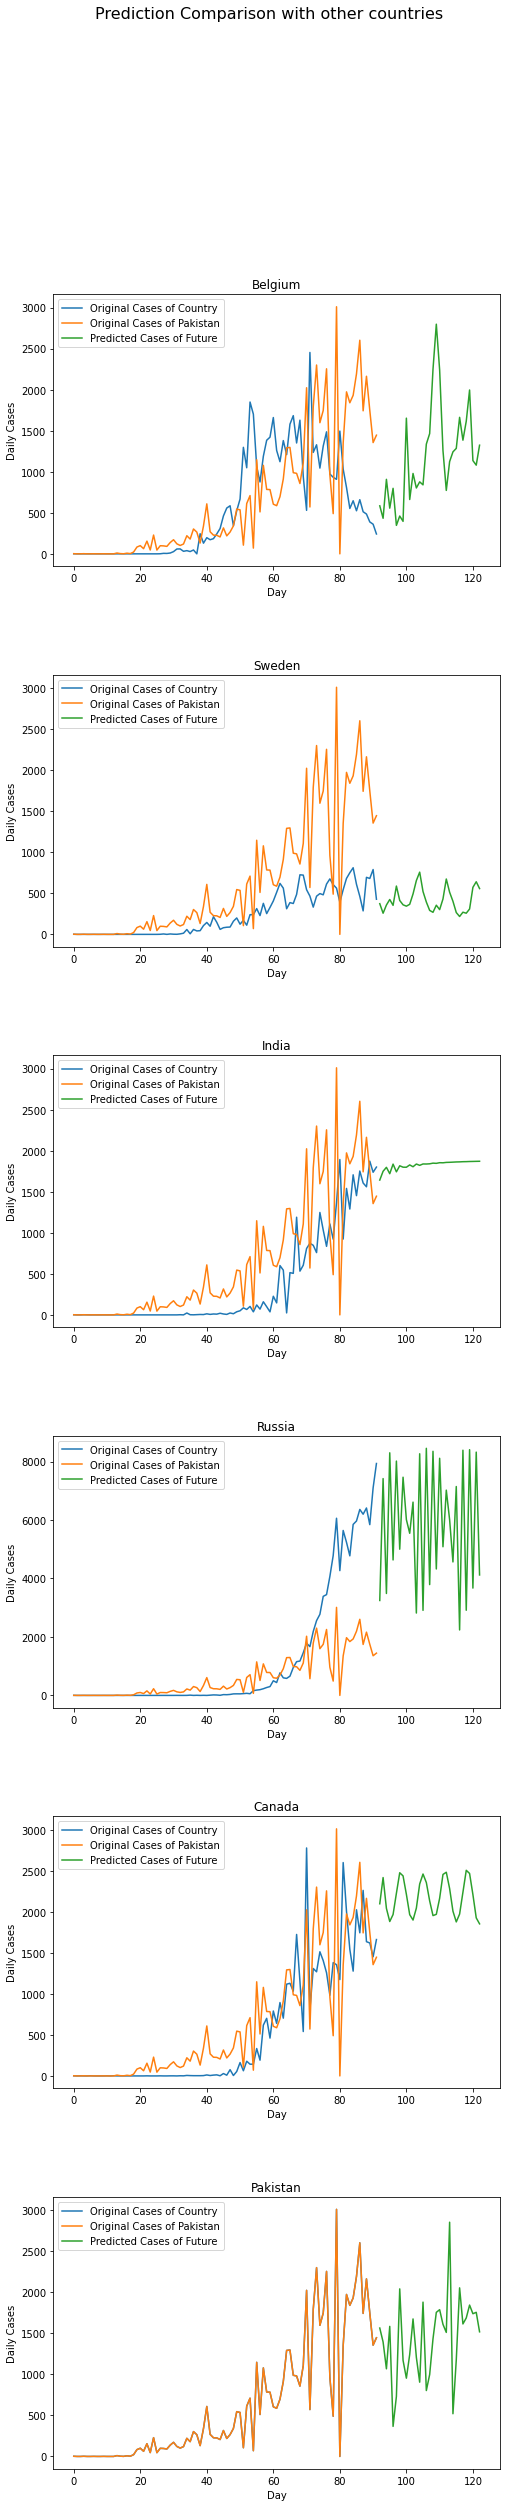

In [208]:
days = [x for x in range(92+31)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days[:92],country_series[:92], label = "Original Cases of Country")
    axs[i].plot(days[:92],pak_series[:-1], label = "Original Cases of Pakistan")
    axs[i].plot(days[92:],pred_trend_fut[country], label = "Predicted Cases of Future")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

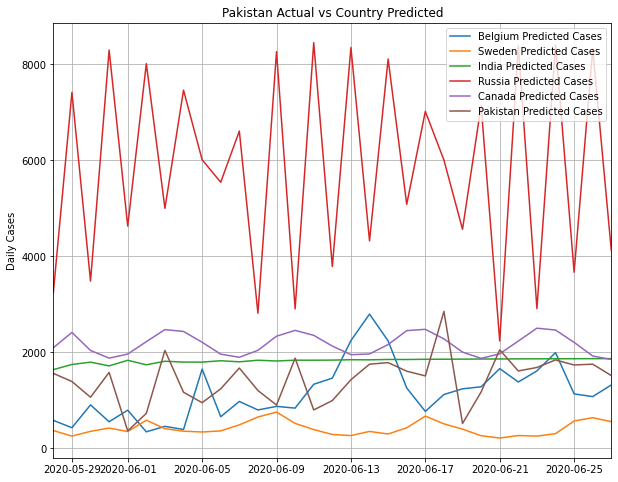

In [209]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
# plt.plot(index,pak_series_test,label = "Pakistan Cases")
for country in pred_trend_fut.keys():
  plt.plot(index,pred_trend_fut[country], label = country+" Predicted Cases")
plt.legend(loc='upper right');

# Current Predictions for Pakistan

In [210]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
# dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  6/9/20  6/10/20  6/11/20  6/12/20
0    Afghanistan  33.0000  65.0000        0  ...   21459    22142    22890    23546
1        Albania  41.1533  20.1683        0  ...    1299     1341     1385     1416
2        Algeria  28.0339   1.6596        0  ...   10382    10484    10589    10698
3        Andorra  42.5063   1.5218        0  ...     852      852      852      853
4         Angola -11.2027  17.8739        0  ...      96      113      118      130

[5 rows x 146 columns]

In [211]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 14  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 108 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 108 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"6/11/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/29/20    2429.0
5/30/20    3039.0
5/31/20    2964.0
6/1/20     3938.0
6/2/20     4065.0
6/3/20     4801.0
6/4/20     3985.0
6/5/20     4734.0
6/6/20     4960.0
6/7/20     4728.0
6/8/20     4646.0
6/9/20     5385.0
6/10/20    5834.0
6/11/20    6397.0
dtype: float64

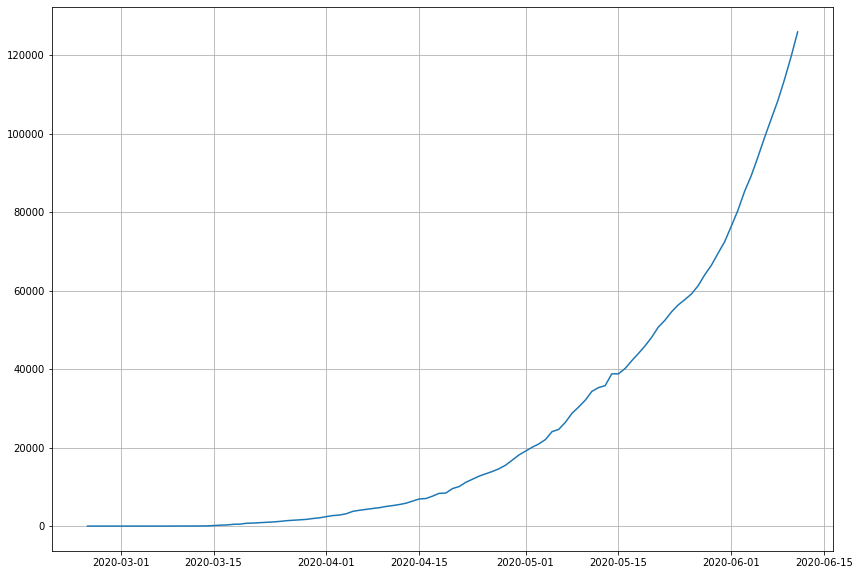

In [212]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'6/11/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

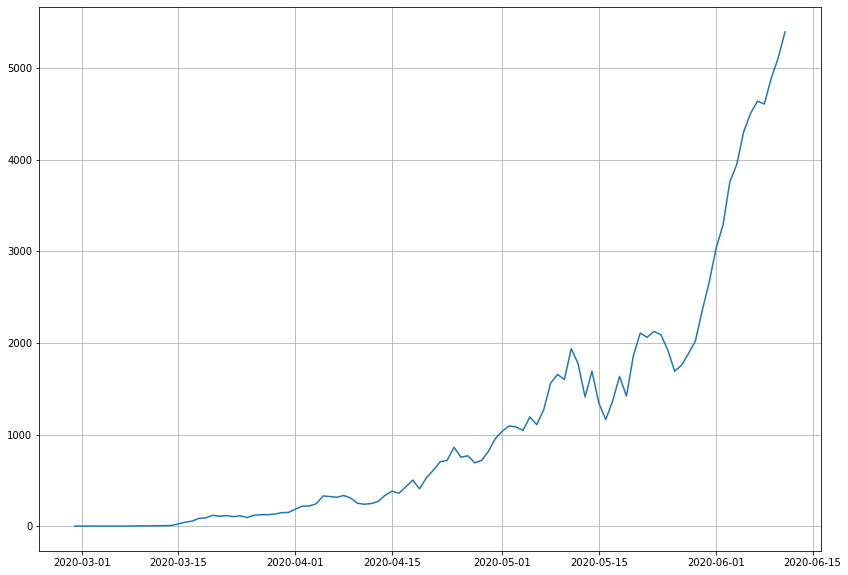

In [213]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
daily_cases = daily_cases.rolling(window = 5).mean()
daily_cases.dropna(inplace = True)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

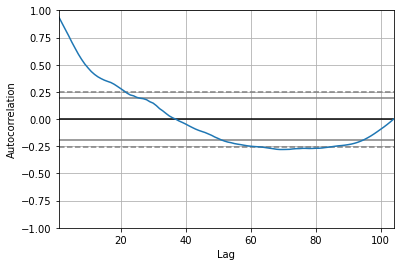

In [214]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 10, as the values are most correalted for that range

In [215]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
train_data = daily_cases
print(train_data.shape)

(104,)


In [216]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [217]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([1.1116e-04, 3.7052e-05, 7.4104e-05, 7.4104e-05, 0.0000e+00]), tensor([3.7052e-05])), (tensor([3.7052e-05, 7.4104e-05, 7.4104e-05, 0.0000e+00, 3.7052e-05]), tensor([3.7052e-05])), (tensor([7.4104e-05, 7.4104e-05, 0.0000e+00, 3.7052e-05, 3.7052e-05]), tensor([0.])), (tensor([7.4104e-05, 0.0000e+00, 3.7052e-05, 3.7052e-05, 0.0000e+00]), tensor([0.])), (tensor([0.0000e+00, 3.7052e-05, 3.7052e-05, 0.0000e+00, 0.0000e+00]), tensor([0.0004])), (tensor([3.7052e-05, 3.7052e-05, 0.0000e+00, 0.0000e+00, 3.7052e-04]), tensor([0.0004])), (tensor([3.7052e-05, 0.0000e+00, 0.0000e+00, 3.7052e-04, 4.4463e-04]), tensor([0.0005])), (tensor([0.0000, 0.0000, 0.0004, 0.0004, 0.0005]), tensor([0.0008])), (tensor([0.0000, 0.0004, 0.0004, 0.0005, 0.0008]), tensor([0.0009])), (tensor([0.0004, 0.0004, 0.0005, 0.0008, 0.0009]), tensor([0.0013])), (tensor([0.0004, 0.0005, 0.0008, 0.0009, 0.0013]), tensor([0.0043])), (tensor([0.0005, 0.0008, 0.0009, 0.0013, 0.0043]), tensor([0.0080])), (tensor([0.0008, 0.

In [218]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,250,train_seq)

Epoch 0 train loss: 0.004153698592557878
Epoch 5 train loss: 0.008416758556710466
Epoch 10 train loss: 0.0020736881795643224
Epoch 15 train loss: 0.0033168001984256045
Epoch 20 train loss: 0.0022825766117803505
Epoch 25 train loss: 0.002532626146499221
Epoch 30 train loss: 0.0017564654210399874
Epoch 35 train loss: 0.001816060501459606
Epoch 40 train loss: 0.0012127686938645747
Epoch 45 train loss: 0.001396821099532483
Epoch 50 train loss: 0.0010812165788750875
Epoch 55 train loss: 0.00124123533527843
Epoch 60 train loss: 0.001024536277597074
Epoch 65 train loss: 0.0011864621023076121
Epoch 70 train loss: 0.0009732233608339592
Epoch 75 train loss: 0.0011557521612237216
Epoch 80 train loss: 0.0009512385794595423
Epoch 85 train loss: 0.0011322685455548603
Epoch 90 train loss: 0.0009374329146340594
Epoch 95 train loss: 0.0011051433286643592
Epoch 100 train loss: 0.0009073292030344152
Epoch 105 train loss: 0.0010662479004419432
Epoch 110 train loss: 0.0008940181497039684
Epoch 115 train lo

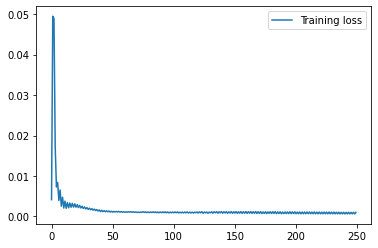

In [219]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [220]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 14
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.014780431985855103, -0.014732301235198975, -0.014762908220291138, -0.014778226613998413, -0.014772027730941772, -0.014456957578659058, -0.014481008052825928, -0.014360636472702026, -0.014121472835540771, -0.014095216989517212, -0.013650178909301758, -0.011143535375595093, -0.008517324924468994, -0.006799608469009399, -0.0014868378639221191, -0.0018181800842285156, 0.004296422004699707, 0.0008262991905212402, 0.004080682992935181, 0.0005941092967987061, 0.0032269954681396484, -0.0010333061218261719, 0.0047574639320373535, 0.003163546323776245, 0.004921704530715942, 0.005599498748779297, 0.008079886436462402, 0.007891714572906494, 0.014785796403884888, 0.01842692494392395, 0.01944097876548767, 0.0245208740234375, 0.037706226110458374, 0.03398090600967407, 0.03786444664001465, 0.03870925307273865, 0.032920628786087036, 0.025311142206192017, 0.024126052856445312, 0.02306842803955078, 0.027586042881011963, 0.0390666127204895, 0.04500502347946167, 0.04269316792488098, 0

In [221]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
actual_predictions[actual_predictions < 0] = 0
# real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] =  np.concatenate((train_pred[-14:].flatten(),actual_predictions.flatten()))

Train RMSE =  176.4054790822457


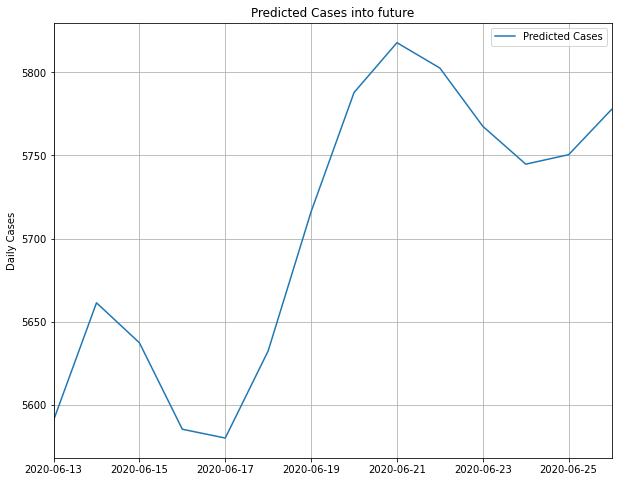

In [222]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-06-13",end="2020-06-26")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

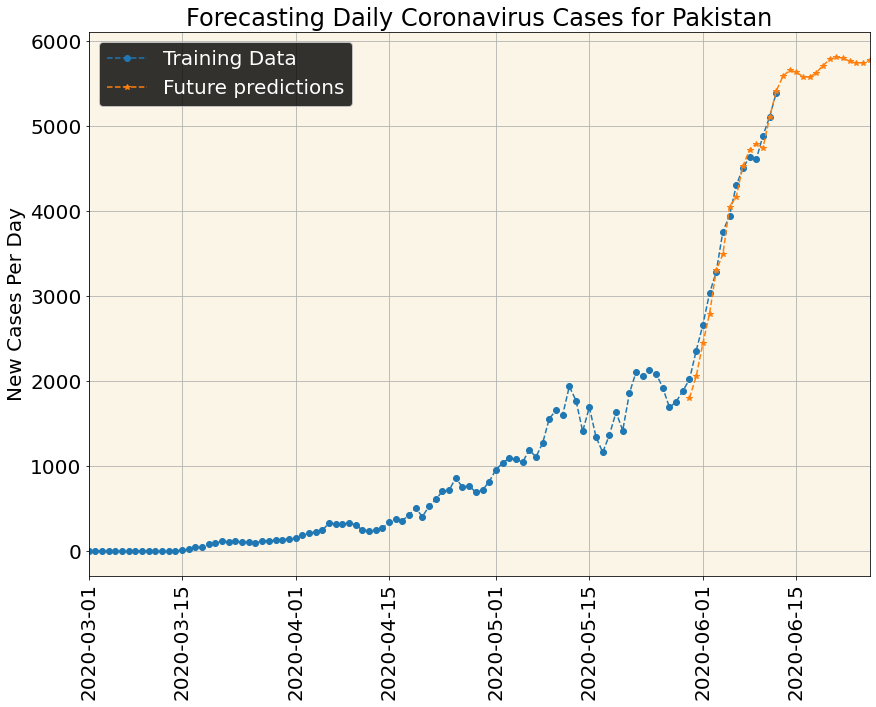

In [223]:
index = pd.date_range(start="2020-03-1",end="2020-06-26")
plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 20})
plt.title('Forecasting Daily Coronavirus Cases for Pakistan')
plt.ylabel("New Cases Per Day")
plt.autoscale(axis='x', tight=True)
ax = plt.gca()
ax.tick_params(axis='x', rotation=90)
ax.set_facecolor('#faf5e6')
plt.grid(True)
plt.plot(
  index[:104],
  train_data.values,
  linestyle='--', marker='o',
  label='Training Data'
)
plt.plot(
  index[104-14:],
  pred_trend_fut[COUNTRY],
  marker='*',linestyle='--',
  label='Future predictions'
)
leg = plt.legend(facecolor='black', framealpha=0.8)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
plt.savefig("pakistan.png",bbox_inches='tight',pad_inches = 0.4)